### Data Understanding and Initial Exploration

Install dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
# Load the raw dataset
df = pd.read_csv('../../data/raw/Coffee Shop Sales.csv')
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,1/1/2023,7:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,1/1/2023,7:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,1/1/2023,7:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,1/1/2023,7:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,1/1/2023,7:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


#### Inspect the Structure

In [3]:
# Check basic info
print(df.info())

# Shape of the dataset
print("Shape:", df.shape)

# Check for missing values
print("Missing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    149116 non-null  int64  
 1   transaction_date  149116 non-null  object 
 2   transaction_time  149116 non-null  object 
 3   transaction_qty   149116 non-null  int64  
 4   store_id          149116 non-null  int64  
 5   store_location    149116 non-null  object 
 6   product_id        149116 non-null  int64  
 7   unit_price        149116 non-null  float64
 8   product_category  149116 non-null  object 
 9   product_type      149116 non-null  object 
 10  product_detail    149116 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.5+ MB
None
Shape: (149116, 11)
Missing values:
 transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_p

#### Summary Statistics

In [4]:
# Summary stats for numeric columns
print(df.describe())

# Unique values in categorical columns
categorical_cols = ['store_location', 'product_category', 'product_type']
for col in categorical_cols:
    print("\n")
    print(f"Unique values in {col}:\n", df[col].value_counts())


       transaction_id  transaction_qty       store_id     product_id  \
count   149116.000000    149116.000000  149116.000000  149116.000000   
mean     74737.371872         1.438276       5.342063      47.918607   
std      43153.600016         0.542509       2.074241      17.930020   
min          1.000000         1.000000       3.000000       1.000000   
25%      37335.750000         1.000000       3.000000      33.000000   
50%      74727.500000         1.000000       5.000000      47.000000   
75%     112094.250000         2.000000       8.000000      60.000000   
max     149456.000000         8.000000       8.000000      87.000000   

          unit_price  
count  149116.000000  
mean        3.382219  
std         2.658723  
min         0.800000  
25%         2.500000  
50%         3.000000  
75%         3.750000  
max        45.000000  


Unique values in store_location:
 store_location
Hell's Kitchen     50735
Astoria            50599
Lower Manhattan    47782
Name: count, dtype

### Data Cleaning & Feature Engineering

In [5]:
import numpy as np
from datetime import datetime, timedelta
import random 

df["unit_cost"] = df["unit_price"] * random.choice([0.75, 0.7, 0.65, 0.63 ,0.61, 0.55])

df['timestamp'] = pd.to_datetime(df['transaction_date'].astype(str) + ' ' +
                               df['transaction_time'].astype(str))
df = df.sort_values("timestamp").reset_index(drop=True)

# Define a time threshold to separate sessions (e.g., 3 minutes)
time_threshold = timedelta(minutes=3)

# Initialize the first customer ID
customer_ids = []
current_customer_id = 5000
last_store_id = df.loc[0, "store_id"]
last_timestamp = df.loc[0, "timestamp"]
customer_ids.append(current_customer_id)

# Loop through and assign customer IDs based on time gaps
for i in range(1, len(df)):
    current_timestamp = df.loc[i, "timestamp"]
    current_store_id = df.loc[i, "store_id"]
    if (current_timestamp - last_timestamp > time_threshold) or (last_store_id != current_store_id):
        current_customer_id += 1
    customer_ids.append(current_customer_id)
    last_timestamp = current_timestamp
    last_store_id = current_store_id

df["customer_id"] = customer_ids

# Preview the updated data
df[["transaction_id", "timestamp", "unit_price", "unit_cost","store_id", "customer_id"]].head(10)


,transaction_id,timestamp,unit_price,unit_cost,store_id,customer_id
0,1,2023-01-01 07:06:11,3.00,2.100,5,5000
1,2,2023-01-01 07:08:56,3.10,2.170,5,5000
2,3,2023-01-01 07:14:04,4.50,3.150,5,5001
3,4,2023-01-01 07:20:24,2.00,1.400,5,5002
4,5,2023-01-01 07:22:41,3.10,2.170,5,5002
5,6,2023-01-01 07:22:41,3.00,2.100,5,5002
6,7,2023-01-01 07:25:49,2.00,1.400,5,5003
7,8,2023-01-01 07:33:34,2.00,1.400,5,5004
8,9,2023-01-01 07:39:13,4.25,2.975,5,5005
9,10,2023-01-01 07:39:34,3.50,2.450,5,5005


In [6]:
# Assuming your DataFrame is named 'df'
# Convert date and time columns to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.time

In [7]:
# Create a combined datetime column for time series analysis
df['datetime'] = pd.to_datetime(df['transaction_date'].astype(str) + ' ' +
                               df['transaction_time'].astype(str))


In [8]:
df.set_index('datetime', inplace=True)

,datetime,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,...,month,day,weekday,hour,profit,profit_margin,date,year,Segment,promo
0,2023-01-01 07:06:11,1,2023-01-01,07:06:11,2,5,lower manhattan,32,3.00,coffee,...,1,1,6,7,1.800,0.3,2023-01-01,2023,Others,False
1,2023-01-01 07:08:56,2,2023-01-01,07:08:56,2,5,lower manhattan,57,3.10,tea,...,1,1,6,7,1.860,0.3,2023-01-01,2023,Others,False
2,2023-01-01 07:14:04,3,2023-01-01,07:14:04,2,5,lower manhattan,59,4.50,drinking chocolate,...,1,1,6,7,2.700,0.3,2023-01-01,2023,Lost Customers,False
3,2023-01-01 07:20:24,4,2023-01-01,07:20:24,1,5,lower manhattan,22,2.00,coffee,...,1,1,6,7,0.600,0.3,2023-01-01,2023,Loyal Customers,False
4,2023-01-01 07:22:41,5,2023-01-01,07:22:41,2,5,lower manhattan,57,3.10,tea,...,1,1,6,7,1.860,0.3,2023-01-01,2023,Loyal Customers,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,2023-06-30 20:18:41,149452,2023-06-30,20:18:41,2,8,hell's kitchen,44,2.50,tea,...,6,30,4,20,1.500,0.3,2023-06-30,2023,Others,False
149112,2023-06-30 20:25:10,149453,2023-06-30,20:25:10,2,8,hell's kitchen,49,3.00,tea,...,6,30,4,20,1.800,0.3,2023-06-30,2023,Others,False
149113,2023-06-30 20:31:34,149454,2023-06-30,20:31:34,1,8,hell's kitchen,45,3.00,tea,...,6,30,4,20,0.900,0.3,2023-06-30,2023,Others,False
149114,2023-06-30 20:57:19,149455,2023-06-30,20:57:19,1,8,hell's kitchen,40,3.75,coffee,...,6,30,4,20,1.125,0.3,2023-06-30,2023,Needs Attention,False


In [9]:
# Calculate revenue
df['total_price'] = df['transaction_qty'] * df['unit_price']

In [10]:
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

#### Check and Convert Data Types

In [11]:
# If 'transaction_time' is string, you can convert it if needed
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S', errors='coerce').dt.time

# Ensure datetime parts are integers
df[['month', 'day', 'weekday', 'hour']] = df[['month', 'day', 'weekday', 'hour']].astype(int)


#### Create New Columns
We can create a few useful features

In [12]:
# Create profit and profit_margin
df['profit'] = (df['unit_price'] - df['unit_cost']) * df['transaction_qty']
df['profit_margin'] = df['profit'] / df['total_price']

# Optional: Extract date parts if not already created
df['date'] = df['transaction_date'].dt.date
df['year'] = df['transaction_date'].dt.year


#### Standardize Text Columns (e.g., lower case)

In [13]:
# Standardize product or location names
df['store_location'] = df['store_location'].str.lower().str.strip()
df['product_category'] = df['product_category'].str.lower().str.strip()
df['product_type'] = df['product_type'].str.lower().str.strip()


In [14]:
df.to_csv("../../data/processed/cleaned_coffee_sales.csv")

### Exploratory Data Analysis (EDA)
This step helps you uncover patterns, trends, and relationships in your dataset through visuals and summary stats.

#### Load the cleaned Dataset

In [15]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../../data/processed/cleaned_coffee_sales.csv", parse_dates=['transaction_date', 'timestamp'])

# Set the index to the datetime if needed
df.set_index('timestamp', inplace=True)

# Display first 5 rows
print(df.head())

                                datetime  transaction_id transaction_date  \
timestamp                                                                   
2023-01-01 07:06:11  2023-01-01 07:06:11               1       2023-01-01   
2023-01-01 07:08:56  2023-01-01 07:08:56               2       2023-01-01   
2023-01-01 07:14:04  2023-01-01 07:14:04               3       2023-01-01   
2023-01-01 07:20:24  2023-01-01 07:20:24               4       2023-01-01   
2023-01-01 07:22:41  2023-01-01 07:22:41               5       2023-01-01   

                    transaction_time  transaction_qty  store_id  \
timestamp                                                         
2023-01-01 07:06:11         07:06:11                2         5   
2023-01-01 07:08:56         07:08:56                2         5   
2023-01-01 07:14:04         07:14:04                2         5   
2023-01-01 07:20:24         07:20:24                1         5   
2023-01-01 07:22:41         07:22:41                2     

#### Sales Performance Overview

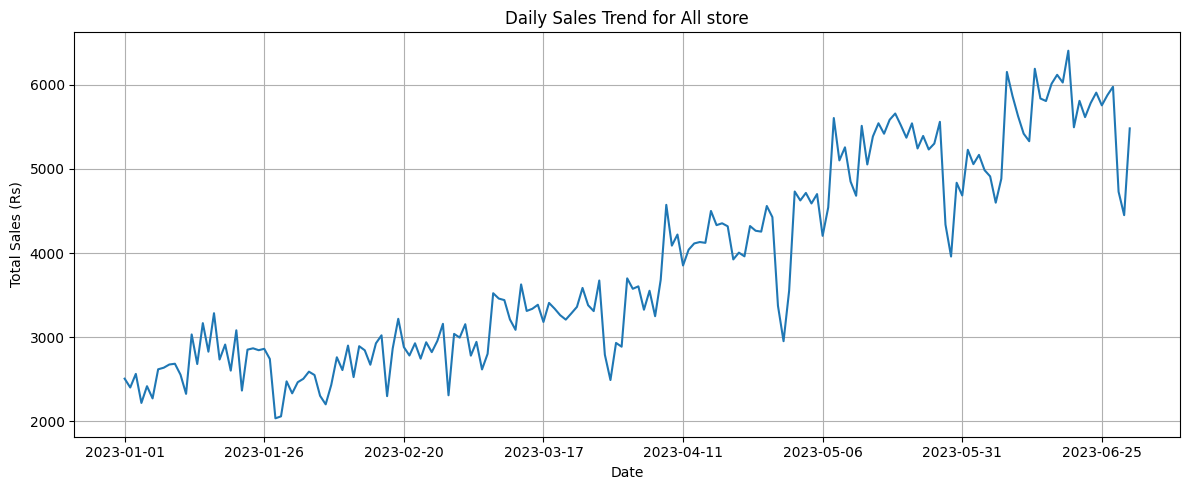

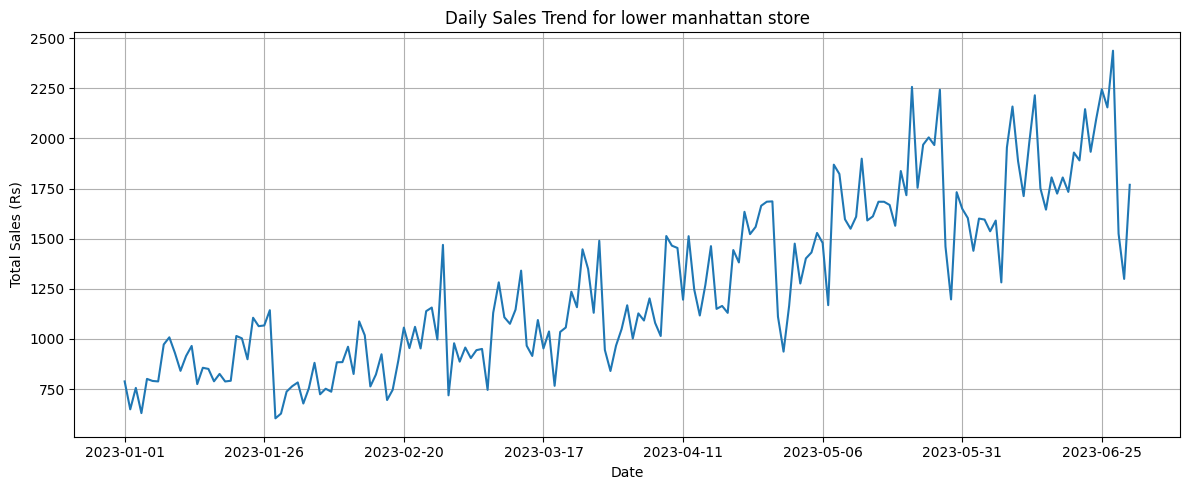

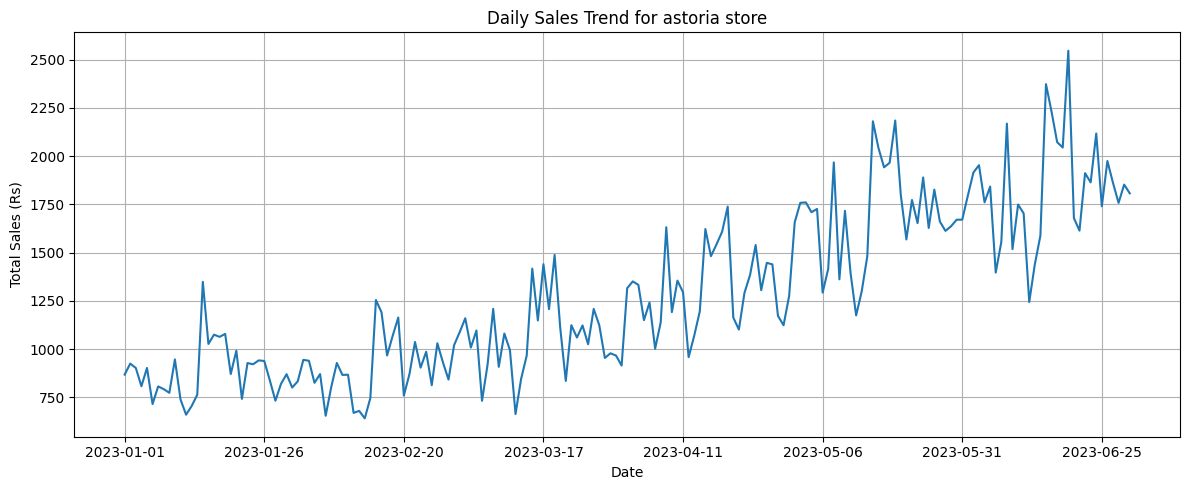

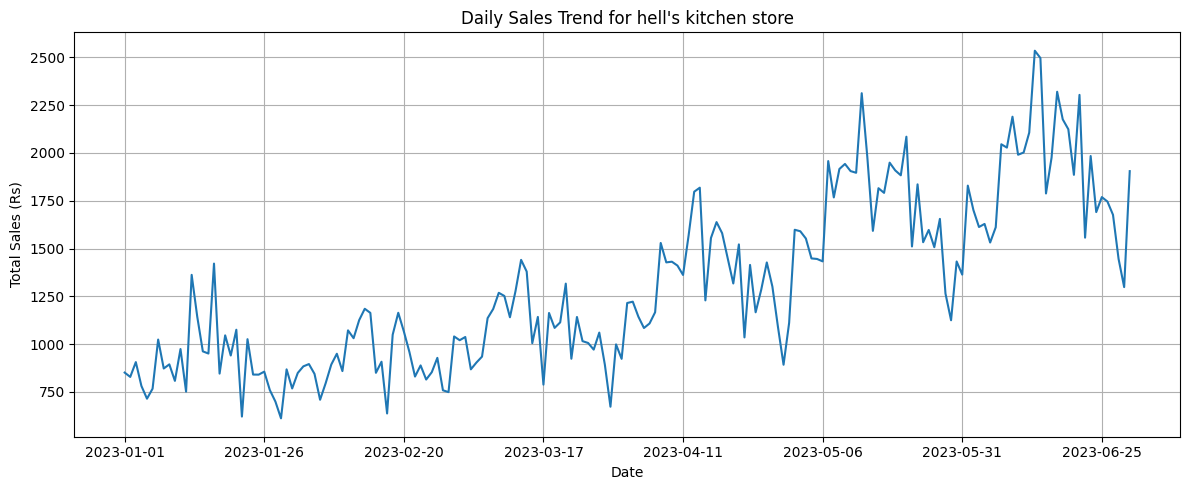

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure inline plotting (if using Jupyter)
%matplotlib inline

# Daily sales trend
daily_sales = df.groupby('date')['total_price'].sum()

plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title('Daily Sales Trend for All store')
plt.xlabel('Date')
plt.ylabel('Total Sales (Rs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Daily sales trend for each store
for i in [5,3,8]:
    daily_sales = df[df['store_id'] == i].groupby('date')['total_price'].sum()
    store_name = df[df['store_id'] == i].iloc[0]['store_location']
    plt.figure(figsize=(12,5))
    daily_sales.plot()
    plt.title(f'Daily Sales Trend for {store_name} store')
    plt.xlabel('Date')
    plt.ylabel('Total Sales (Rs)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


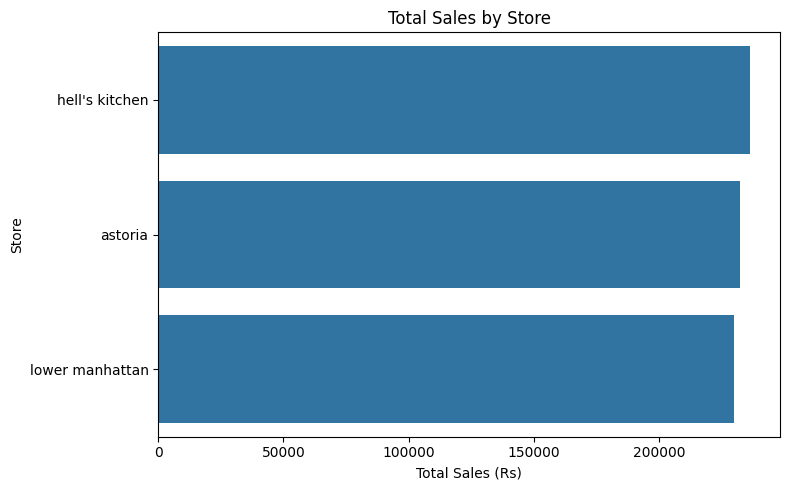

In [17]:
# Total sales by store
store_sales = df.groupby('store_location')['total_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=store_sales.values, y=store_sales.index)
plt.title('Total Sales by Store')
plt.xlabel('Total Sales (Rs)')
plt.ylabel('Store')
plt.tight_layout()
plt.show()


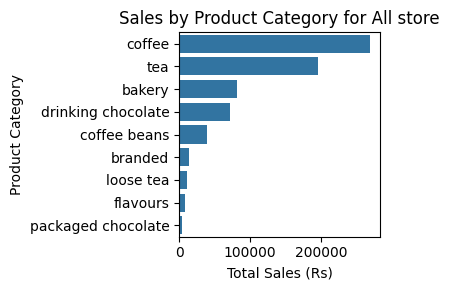

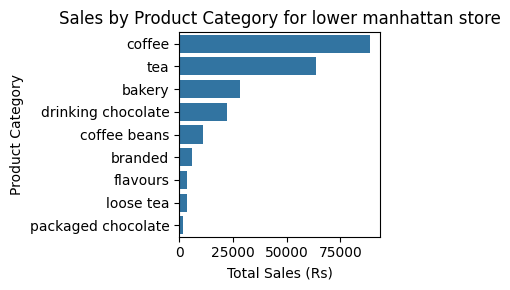

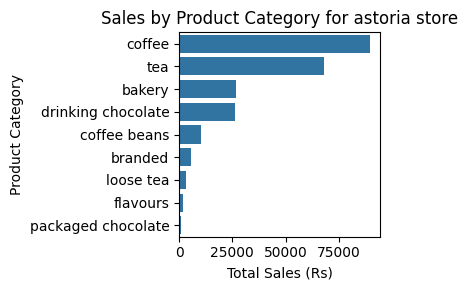

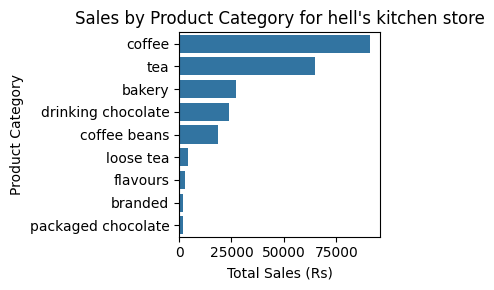

In [18]:
# Sales by product category
category_sales = df.groupby('product_category')['total_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(4,3))
sns.barplot(x=category_sales.values, y=category_sales.index)
plt.title('Sales by Product Category for All store')
plt.xlabel('Total Sales (Rs)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

# Daily sales trend for each store 
for i in [5,3,8]:
    category_sales = df[df['store_id'] == i].groupby('product_category')['total_price'].sum().sort_values(ascending=False)
    store_name = df[df['store_id'] == i].iloc[0]['store_location']
    plt.figure(figsize=(4,3))
    sns.barplot(x=category_sales.values, y=category_sales.index)
    plt.title(f'Sales by Product Category for {store_name} store')
    plt.xlabel('Total Sales (Rs)')
    plt.ylabel('Product Category')
    plt.tight_layout()
    plt.show()


#### Customer-Wise Product Sales Frequency

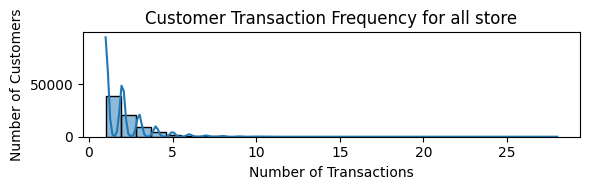

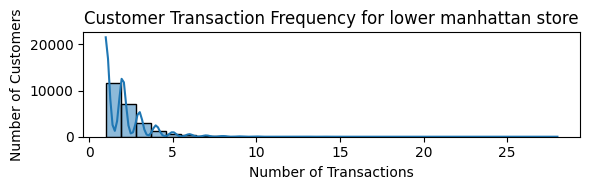

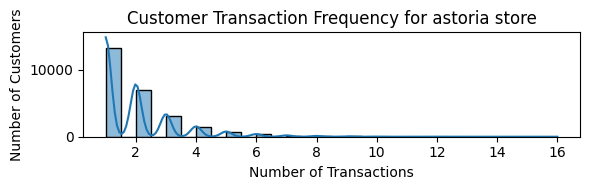

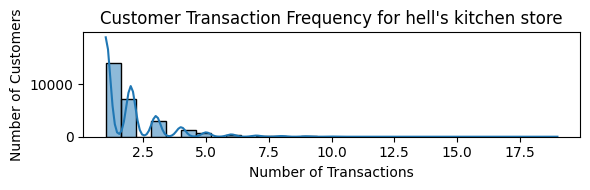

In [19]:
# Number of transactions per customer
customer_txn_count = df['customer_id'].value_counts()

plt.figure(figsize=(6,2))
sns.histplot(customer_txn_count, bins=30, kde=True)
plt.title("Customer Transaction Frequency for all store")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

# Daily sales trend for each store 
for i in [5,3,8]:
    customer_txn_count = df[df['store_id'] == i]['customer_id'].value_counts()
    store_name = df[df['store_id'] == i].iloc[0]['store_location']
    plt.figure(figsize=(6,2))
    sns.histplot(customer_txn_count, bins=30, kde=True)
    plt.title(f"Customer Transaction Frequency for {store_name} store")
    plt.xlabel("Number of Transactions")
    plt.ylabel("Number of Customers")
    plt.tight_layout()
    plt.show()




In [20]:
#Top 10 Customers by Purchase Frequency by each store
for i in [5,3,8]:
    store_name = df[df['store_id'] == i].iloc[0]['store_location']
    top_customers = df[df['store_id'] == i]['customer_id'].value_counts().head(10)
    print(f"Top 10 customers by number of transactions in {store_name} store :\n", top_customers)
    print()


Top 10 customers by number of transactions in lower manhattan store :
 customer_id
76640    28
43159    27
76128    27
76125    24
72595    24
73843    23
56241    22
58874    21
69704    21
58380    19
Name: count, dtype: int64

Top 10 customers by number of transactions in astoria store :
 customer_id
18807    16
66444    15
67353    14
29259    14
42423    13
50200    13
67311    13
67392    13
48992    13
13351    13
Name: count, dtype: int64

Top 10 customers by number of transactions in hell's kitchen store :
 customer_id
54590    19
40238    19
72071    18
17072    16
68492    16
18448    16
71184    15
68478    15
6997     15
45997    15
Name: count, dtype: int64



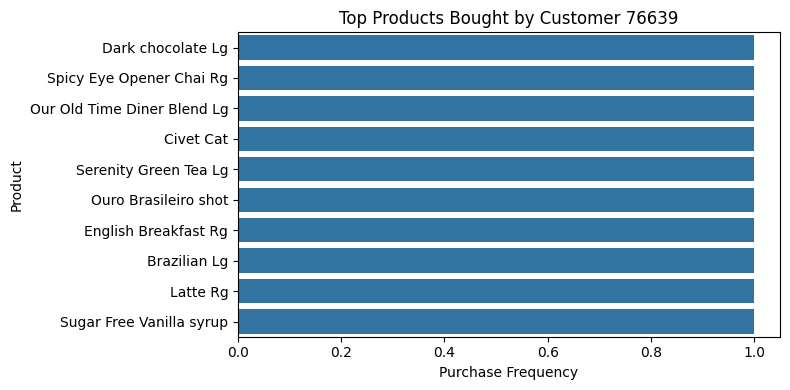

In [21]:
#A Top Products per Customer (example: top customer_id = 76639)

customer_id = 76639  # Replace with actual ID
cust_products = df[df['customer_id'] == customer_id]['product_detail'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=cust_products.values, y=cust_products.index)
plt.title(f"Top Products Bought by Customer {customer_id}")
plt.xlabel("Purchase Frequency")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


In [22]:
#Frequent Product-Customer Matrix (Optional Pivot Table)
#You can create a matrix for advanced customer-product behavior analysis.
customer_product_matrix = pd.pivot_table(
    df, 
    index='customer_id', 
    columns='product_detail', 
    values='transaction_id', 
    aggfunc='count',
    fill_value=0
)

print(customer_product_matrix.head())


product_detail  Almond Croissant  Brazilian - Organic  Brazilian Lg  \
customer_id                                                           
5000                           0                    0             0   
5001                           0                    0             0   
5002                           0                    0             0   
5003                           0                    0             0   
5004                           0                    0             0   

product_detail  Brazilian Rg  Brazilian Sm  Cappuccino  Cappuccino Lg  \
customer_id                                                             
5000                       0             0           0              0   
5001                       0             0           0              0   
5002                       0             0           0              0   
5003                       0             0           0              0   
5004                       0             0           0          

You can create a matrix for advanced customer-product behavior analysis.

This matrix is useful for:

 - Customer segmentation
 - Market basket analysis
 - Collaborative filtering for recommendation systems

#### Time-Based Sales Patterns
Analyzing time-based patterns helps optimize staffing, inventory, and promotions by understanding when sales happen most.

We’ll look at:

 - Sales by hour of the day
 - Sales by day of the week
 - Sales by month

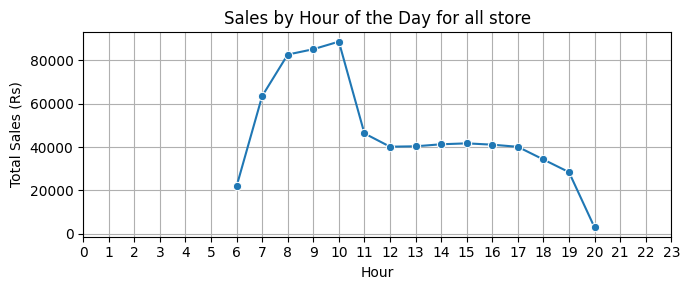

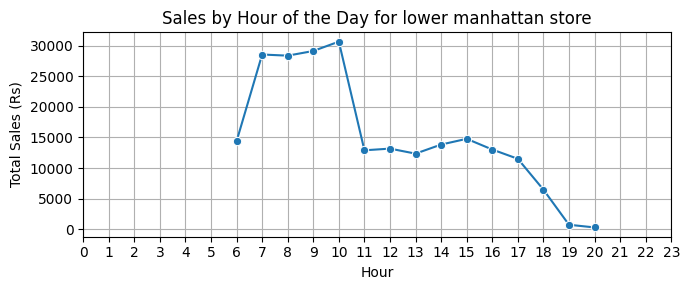

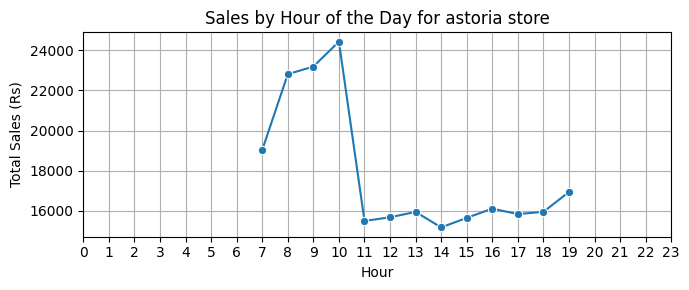

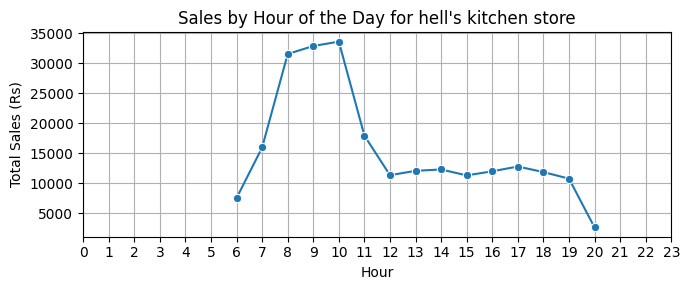

In [23]:
#Sales by Hour

hourly_sales = df.groupby('hour')['total_price'].sum()
plt.figure(figsize=(7,3))
sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, marker='o')
plt.title("Sales by Hour of the Day for all store")
plt.xlabel("Hour")
plt.ylabel("Total Sales (Rs)")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()

# Sales by Hour of the Day for each store 
for i in [5,3,8]:
    hourly_sales = df[df['store_id'] == i].groupby('hour')['total_price'].sum()
    store_name = df[df['store_id'] == i].iloc[0]['store_location']
    plt.figure(figsize=(7,3))
    sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, marker='o')
    plt.title(f"Sales by Hour of the Day for {store_name} store")
    plt.xlabel("Hour")
    plt.ylabel("Total Sales (Rs)")
    plt.xticks(range(0,24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


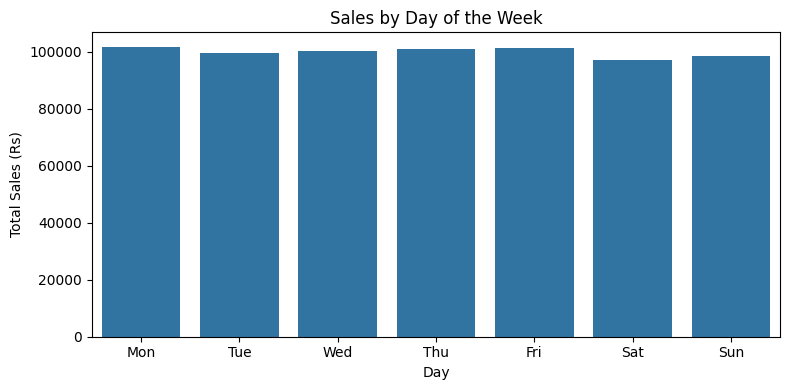

In [24]:
#Sales by Day of the Week
#(Assuming 0 = Monday, 6 = Sunday)

weekday_sales = df.groupby('weekday')['total_price'].sum()

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8,4))
sns.barplot(x=days, y=weekday_sales.values)
plt.title("Sales by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Total Sales (Rs)")
plt.tight_layout()
plt.show()



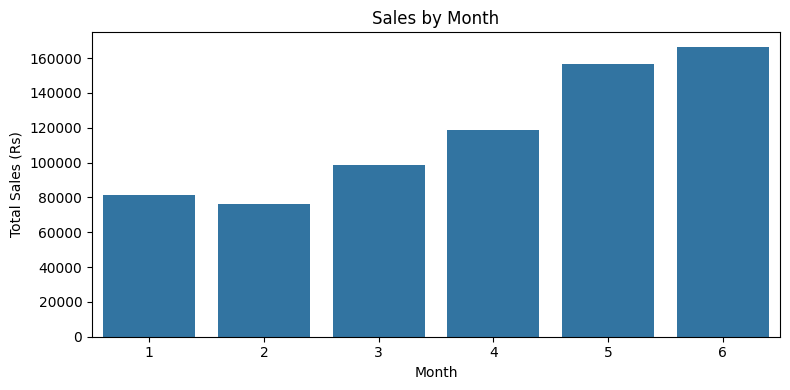

In [25]:
#Sales by Month
monthly_sales = df.groupby('month')['total_price'].sum()

plt.figure(figsize=(8,4))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title("Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales (Rs)")
plt.tight_layout()
plt.show()


#### Product Profitability Analysis
We’ll explore:

 - Profit per product
 - Profit per category
 - High sales but low profit products (important for pricing strategy)

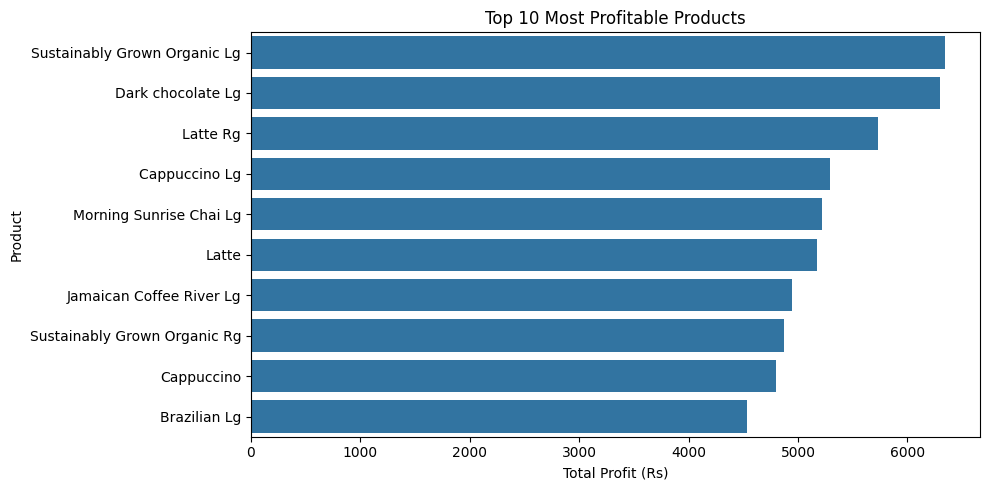

In [26]:
#Total Profit by Product
product_profit = df.groupby('product_detail')['profit'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=product_profit.values, y=product_profit.index)
plt.title("Top 10 Most Profitable Products")
plt.xlabel("Total Profit (Rs)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


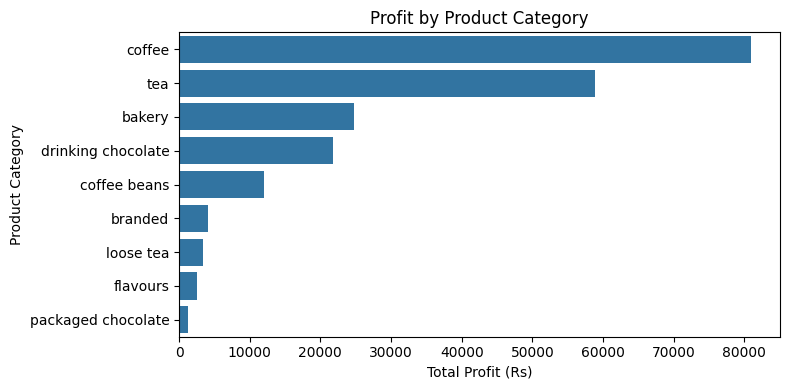

In [27]:
#Total Profit by Product Category
category_profit = df.groupby('product_category')['profit'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=category_profit.values, y=category_profit.index)
plt.title("Profit by Product Category")
plt.xlabel("Total Profit (Rs)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


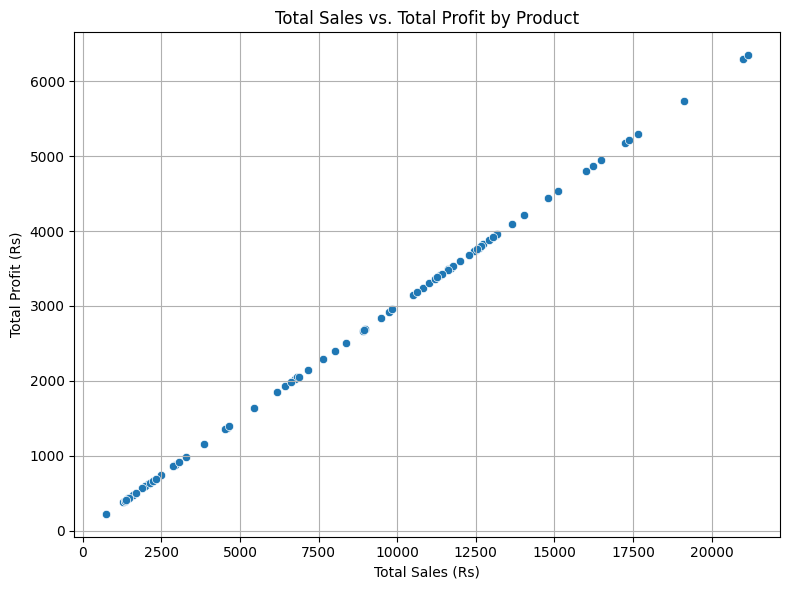

In [28]:
#Sales vs. Profit Comparison
#This helps spot high-volume but low-profit products.
product_sales = df.groupby('product_detail')[['total_price', 'profit']].sum()

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=product_sales, x='total_price', y='profit')
plt.title("Total Sales vs. Total Profit by Product")
plt.xlabel("Total Sales (Rs)")
plt.ylabel("Total Profit (Rs)")
plt.grid(True)
plt.tight_layout()
plt.show()


These insights help guide:

 - Inventory decisions
 - Promotional focus
 - Discounting strategies

#### Customer Segmentation
Customer segmentation helps identify groups like:

 - Loyal customers
 - High spenders
 - Occasional visitors
 - Discount-sensitive buyers

We'll use RFM analysis — a classic customer profiling method.

What is RFM?
 - R (Recency): Days since last purchase (lower is better)
 - F (Frequency): Number of transactions
 - M (Monetary): Total amount spent

In [29]:
df['transaction_date'].max() + pd.Timedelta(days=1)

Timestamp('2023-07-01 00:00:00')

In [30]:
#Calculate RFM Metrics
import datetime as dt

# Reference date: one day after the latest transaction
latest_date = df['transaction_date'].max() + pd.Timedelta(days=1)

# RFM table
rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (latest_date - x.max()).days,
    'transaction_id': 'count',
    'total_price': 'sum'
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

print(rfm.head())


             Recency  Frequency  Monetary
customer_id                              
5000             181          2      12.2
5001             181          1       9.0
5002             181          3      11.2
5003             181          1       2.0
5004             181          1       4.0


In [31]:
#Score Each Metric (1–5)
# Assign scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine into a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].head())


             Recency  Frequency  Monetary RFM_Score
customer_id                                        
5000             181          2      12.2       134
5001             181          1       9.0       114
5002             181          3      11.2       144
5003             181          1       2.0       111
5004             181          1       4.0       112


In [32]:
#Interpret Segments
#You can now group customers:
# Example segment definitions (simplified)
rfm['Segment'] = 'Others'
rfm.loc[rfm['RFM_Score'] == '555', 'Segment'] = 'Champions'
rfm.loc[rfm['R_Score'] == '5', 'Segment'] = 'Recent Customers'
rfm.loc[rfm['F_Score'] == '5', 'Segment'] = 'Loyal Customers'
rfm.loc[rfm['M_Score'] == '5', 'Segment'] = 'Big Spenders'

print(rfm['Segment'].value_counts())


Segment
Others       74289
Champions     2822
Name: count, dtype: int64


In [33]:
rfm.loc[(rfm['R_Score'] >= 4) & (rfm['F_Score'] >= 4), 'Segment'] = 'Loyal Customers'
rfm.loc[(rfm['R_Score'] >= 3) & (rfm['F_Score'] <= 2), 'Segment'] = 'At Risk'
rfm.loc[(rfm['R_Score'] <= 2) & (rfm['F_Score'] >= 4), 'Segment'] = 'Needs Attention'
rfm.loc[(rfm['R_Score'] == 1) & (rfm['F_Score'] == 1), 'Segment'] = 'Lost Customers'
rfm.loc[rfm['RFM_Score'] == '555', 'Segment'] = 'Champions'
print(rfm['Segment'].value_counts())

Segment
Needs Attention    24911
Others             22422
At Risk            15867
Lost Customers      7978
Loyal Customers     3111
Champions           2822
Name: count, dtype: int64


In [34]:
rfm = rfm.reset_index()

In [35]:
# Merge RFM Segment into main DataFrame
df = df.merge(rfm[['customer_id', 'Segment']], on='customer_id', how='left')

In [36]:
df.to_csv("../../data/processed/cleaned_coffee_sales.csv")

#### Sales Forecasting
Sales forecasting helps predict future demand so managers can:

 - Plan inventory ✅
 - Adjust staffing 📋
 - Schedule promotions 🎯

We’ll create a time series forecast using daily sales data.

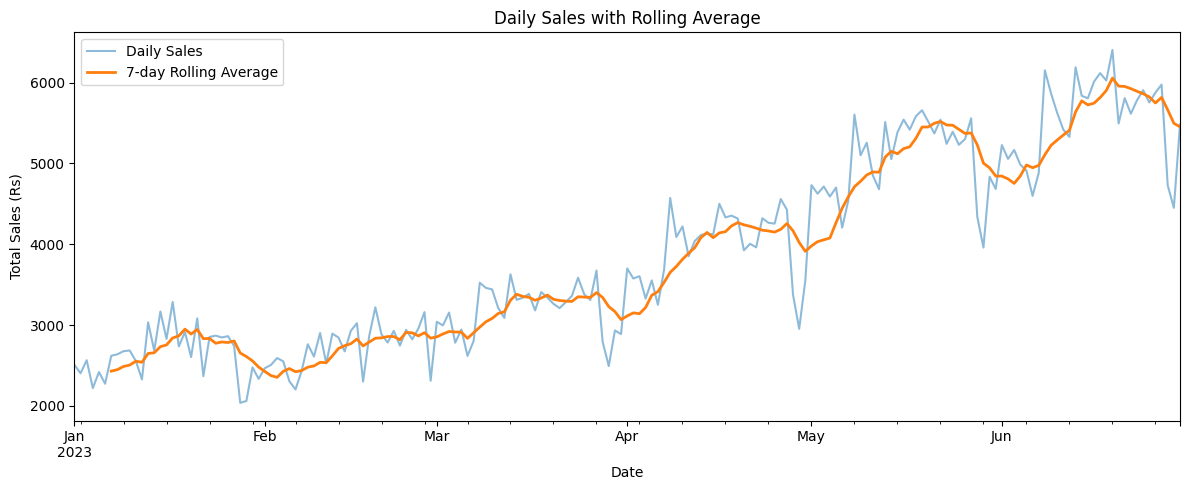

In [37]:
#Prepare Time Series Data
# Convert to daily total sales
daily_sales = df.groupby('transaction_date')['total_price'].sum()

# Make sure it's a proper datetime index
daily_sales.index = pd.to_datetime(daily_sales.index)

# Optional: smooth data using rolling average
daily_sales_rolling = daily_sales.rolling(window=7).mean()

# Plot original and rolling
plt.figure(figsize=(12,5))
daily_sales.plot(label='Daily Sales', alpha=0.5)
daily_sales_rolling.plot(label='7-day Rolling Average', linewidth=2)
plt.title("Daily Sales with Rolling Average")
plt.xlabel("Date")
plt.ylabel("Total Sales (Rs)")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


d:\GitHub\DS_project-coffee_shop_sales_analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:53 - cmdstanpy - INFO - Chain [1] done processing


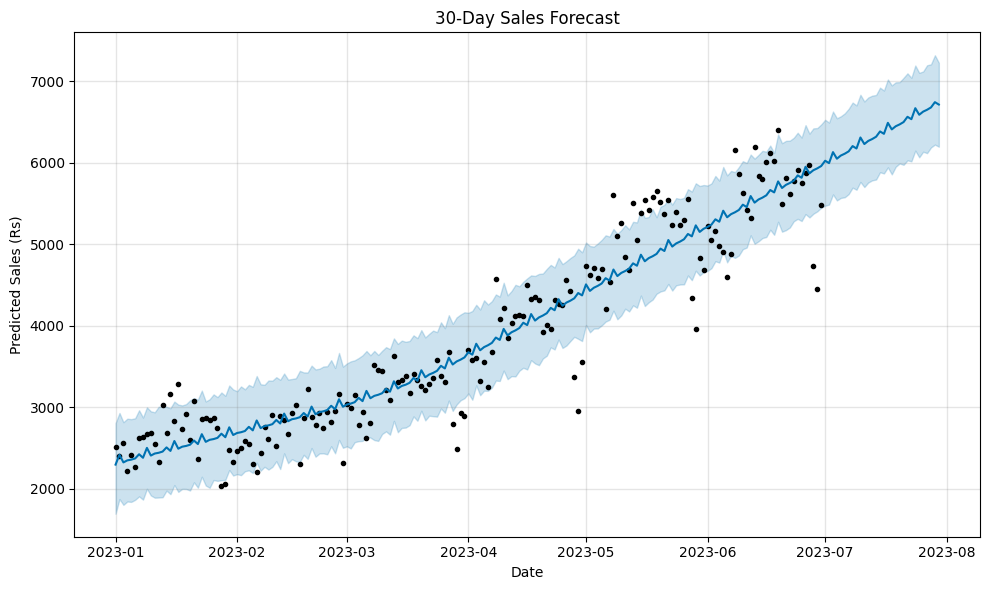

In [39]:
#Build a Simple Forecast Model (using Prophet)
#We'll use Facebook Prophet, a powerful time series tool.
from prophet import Prophet

# Prepare data for Prophet
sales_df = daily_sales.reset_index()
sales_df.columns = ['ds', 'y']  # Prophet expects these column names

# Initialize and fit model
model = Prophet()
model.fit(sales_df)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("30-Day Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Sales (Rs)")
plt.tight_layout()
plt.show()


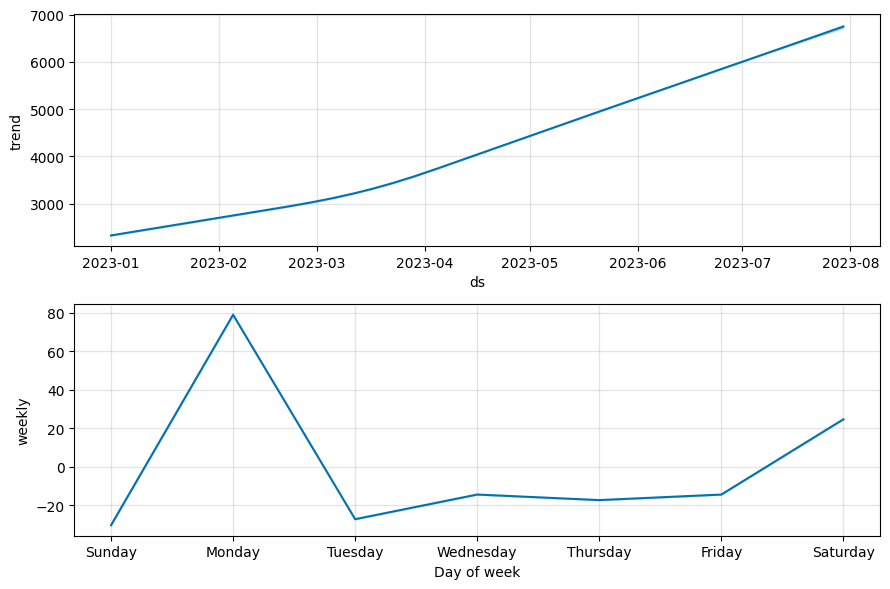

In [40]:
#View Forecast Components
model.plot_components(forecast)
plt.tight_layout()
plt.show()


#### Enhancements for Sales Forecasting

1. 📍 Forecast Sales by Store
Forecast demand for each store individually — helps plan staffing and stock levels.

16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Store ID: 5


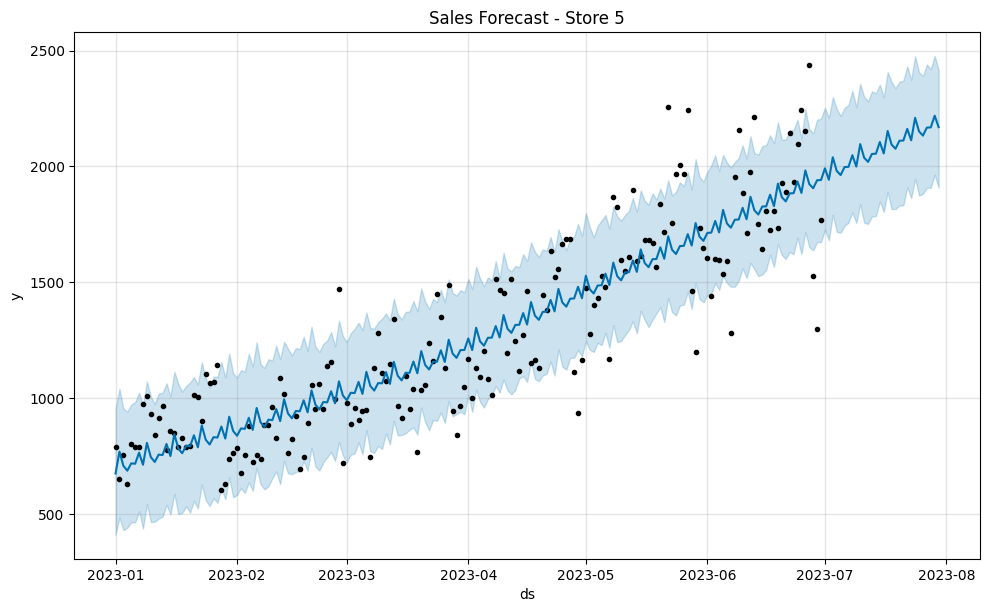

16:42:56 - cmdstanpy - INFO - Chain [1] start processing
16:42:56 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Store ID: 8


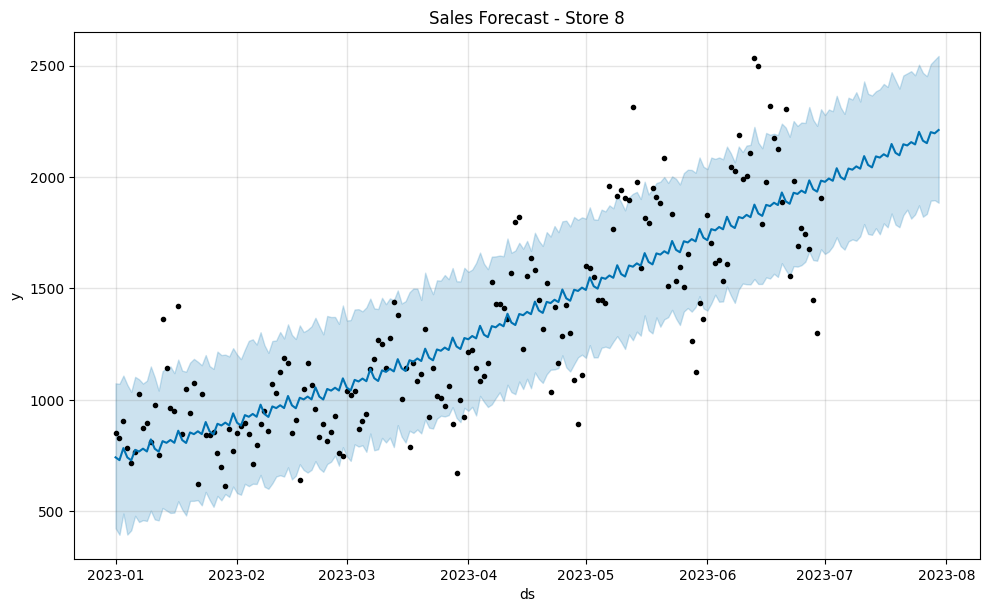

16:42:57 - cmdstanpy - INFO - Chain [1] start processing
16:42:57 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Store ID: 3


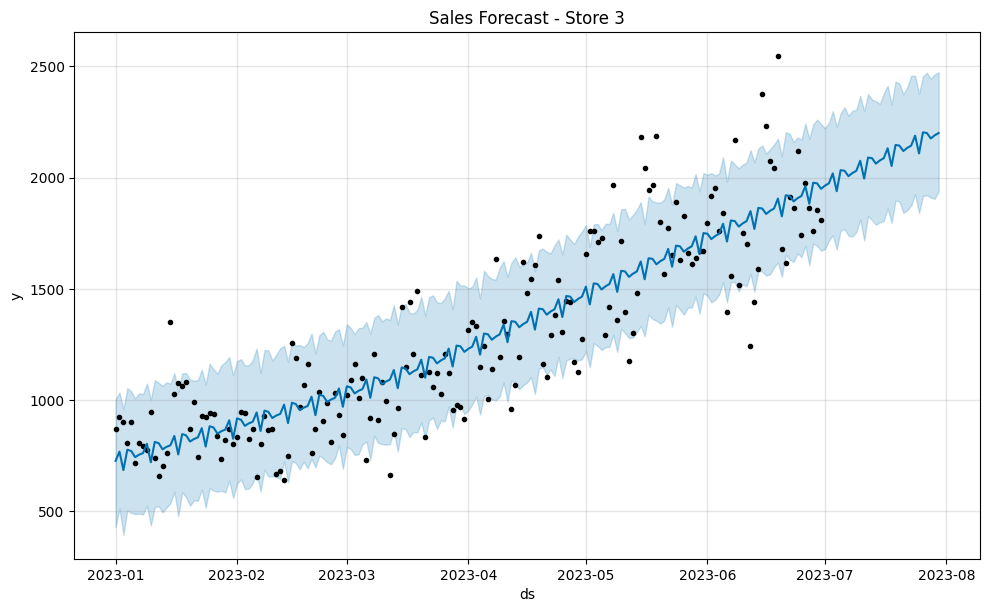

In [41]:
store_ids = df['store_id'].unique()

for store in store_ids:
    store_sales = df[df['store_id'] == store].groupby('transaction_date')['total_price'].sum().reset_index()
    store_sales.columns = ['ds', 'y']

    m = Prophet()
    m.fit(store_sales)
    
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    print(f"Forecast for Store ID: {store}")
    m.plot(forecast)
    plt.title(f"Sales Forecast - Store {store}")
    plt.show()


2. 🛍️ Forecast Sales by Product Category

Same idea — but by product category instead of location.

16:42:58 - cmdstanpy - INFO - Chain [1] start processing
16:42:58 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: coffee


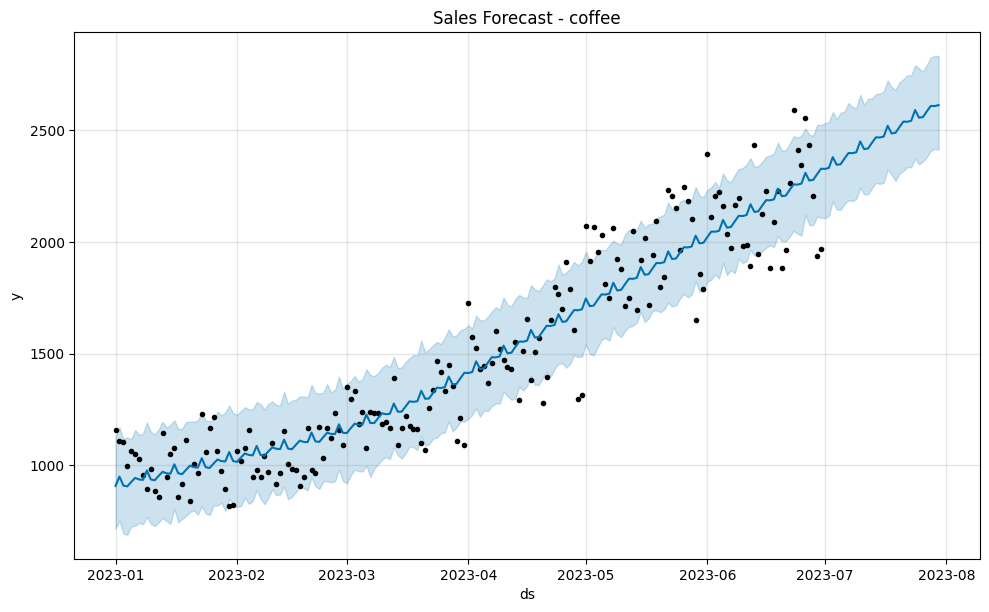

16:42:58 - cmdstanpy - INFO - Chain [1] start processing
16:42:58 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: tea


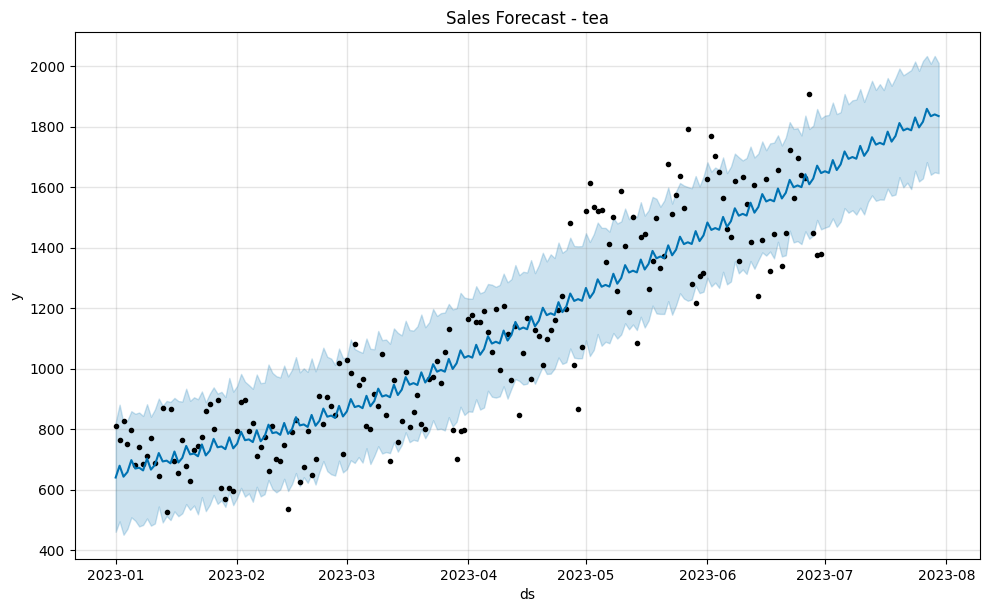

16:42:59 - cmdstanpy - INFO - Chain [1] start processing
16:42:59 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: drinking chocolate


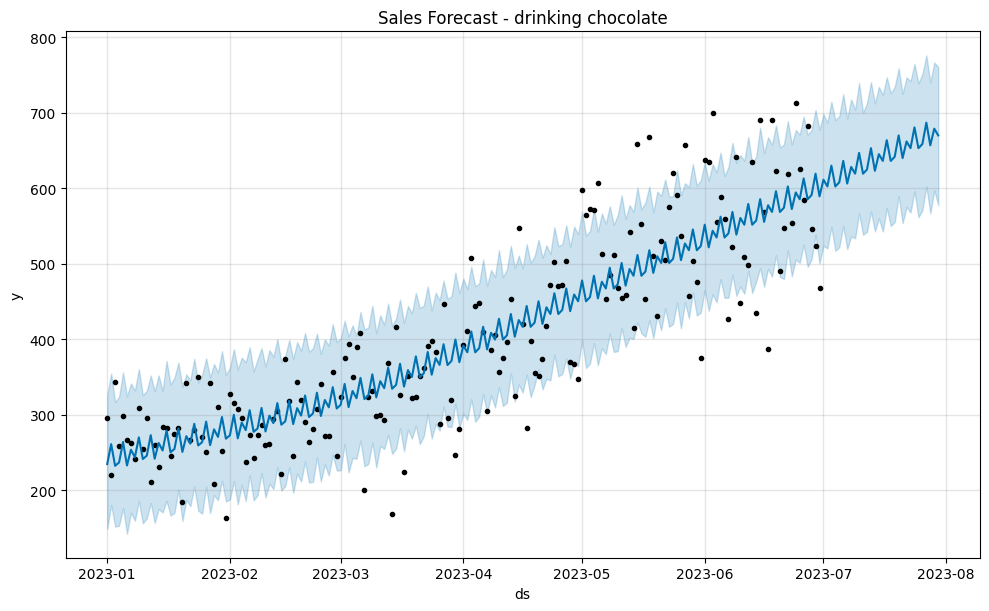

16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: bakery


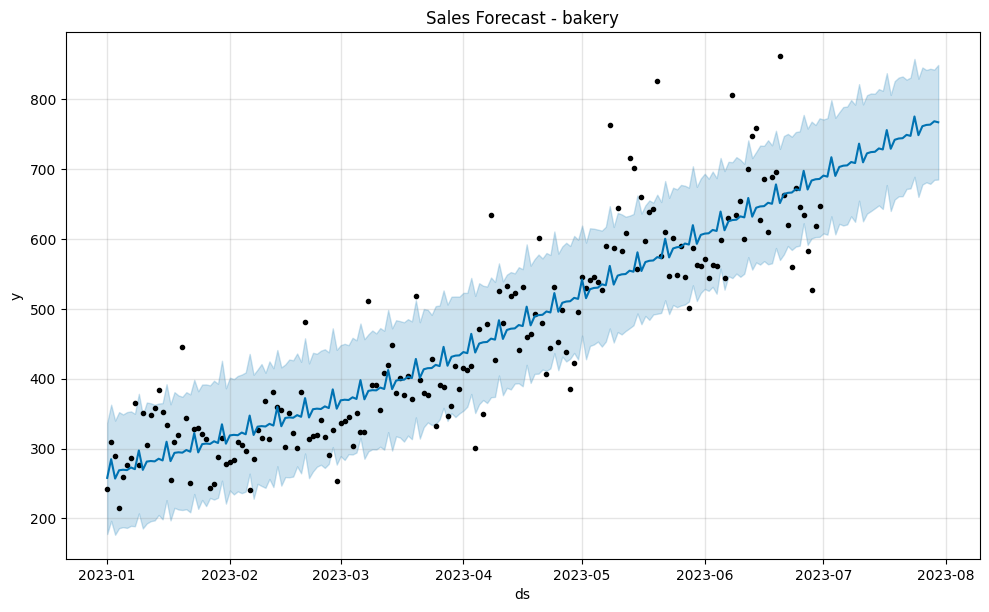

16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: flavours


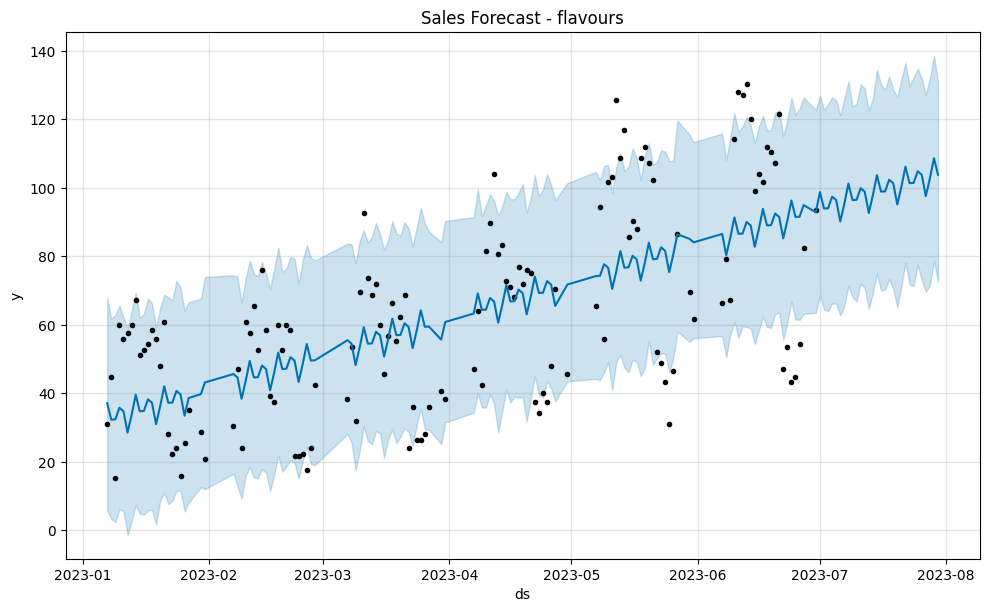

16:43:01 - cmdstanpy - INFO - Chain [1] start processing
16:43:01 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: loose tea


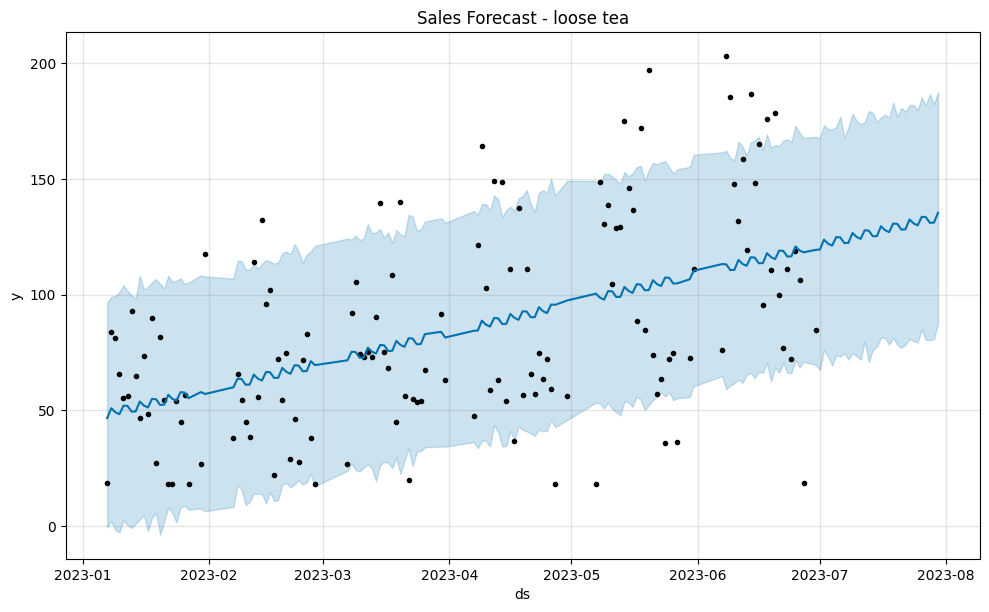

16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: coffee beans


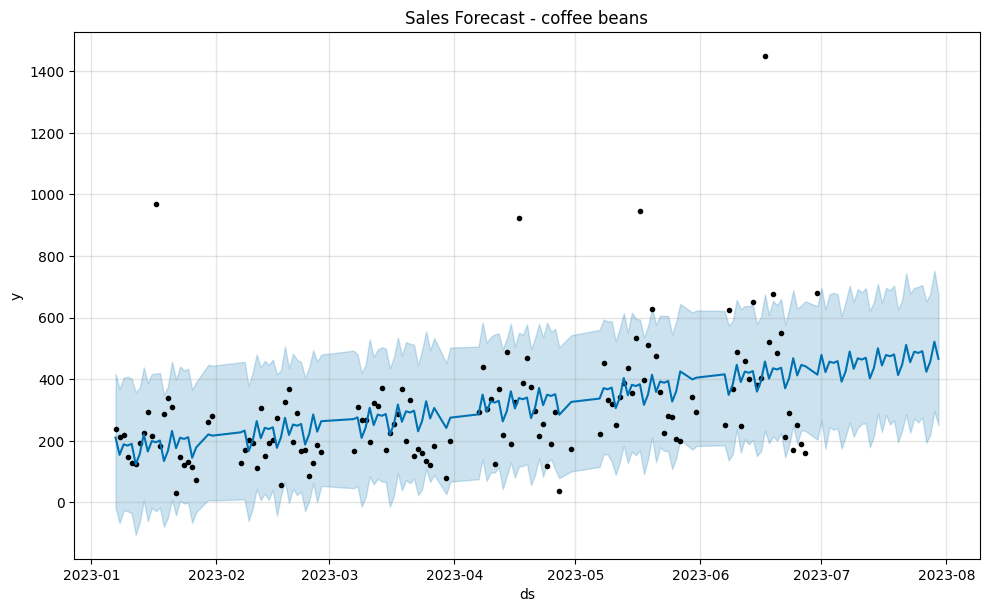

16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: packaged chocolate


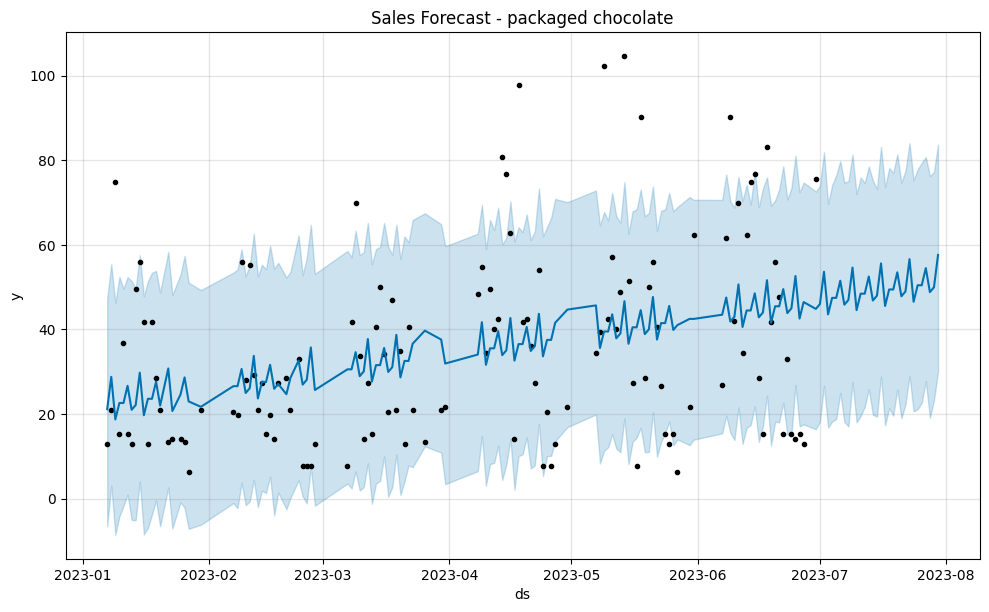

16:43:03 - cmdstanpy - INFO - Chain [1] start processing
16:43:03 - cmdstanpy - INFO - Chain [1] done processing


Forecast for Category: branded


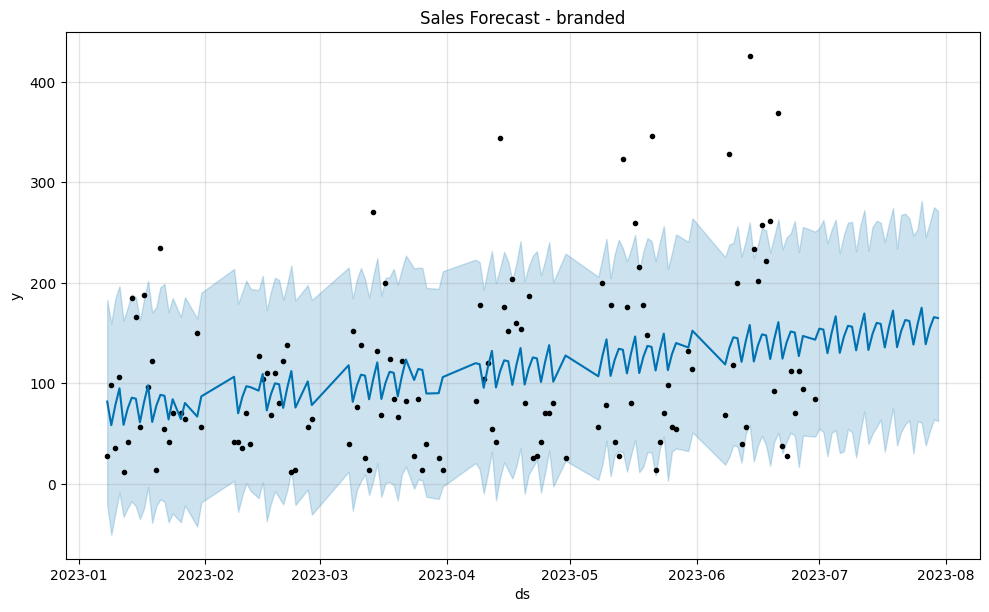

In [42]:
categories = df['product_category'].unique()

for cat in categories:
    cat_sales = df[df['product_category'] == cat].groupby('transaction_date')['total_price'].sum().reset_index()
    cat_sales.columns = ['ds', 'y']

    m = Prophet()
    m.fit(cat_sales)
    
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    print(f"Forecast for Category: {cat}")
    m.plot(forecast)
    plt.title(f"Sales Forecast - {cat}")
    plt.show()


### Advanced Forecasting with ARIMA or LSTM

#### ARIMA (AutoRegressive Integrated Moving Average)
Best for linear time series with trends or seasonality.

Sales Forecast with ARIMA

In [43]:
# Install Required Library
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


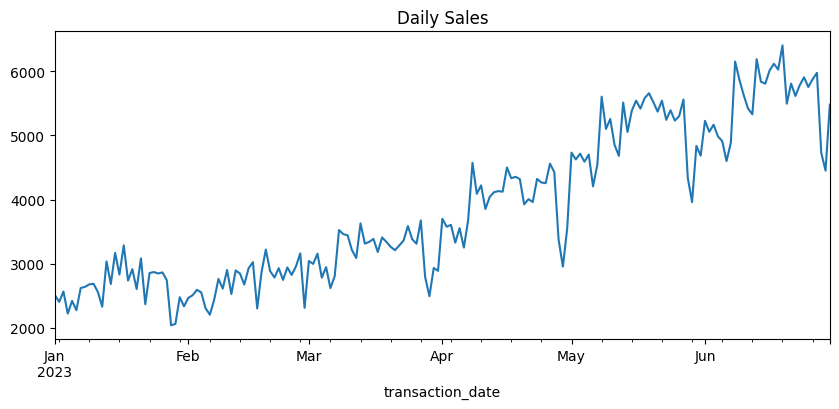

In [44]:
# Prepare Daily Sales Series
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Daily total sales
daily_sales = df.groupby('transaction_date')['total_price'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)

# Visual check
daily_sales.plot(figsize=(10,4), title="Daily Sales")
plt.show()


transaction_date
2023-01-01    2508.20
2023-01-02    2403.35
2023-01-03    2565.00
2023-01-04    2220.10
2023-01-05    2418.85
               ...   
2023-06-26    5875.90
2023-06-27    5975.65
2023-06-28    4728.90
2023-06-29    4450.75
2023-06-30    5481.32
Name: total_price, Length: 181, dtype: float64

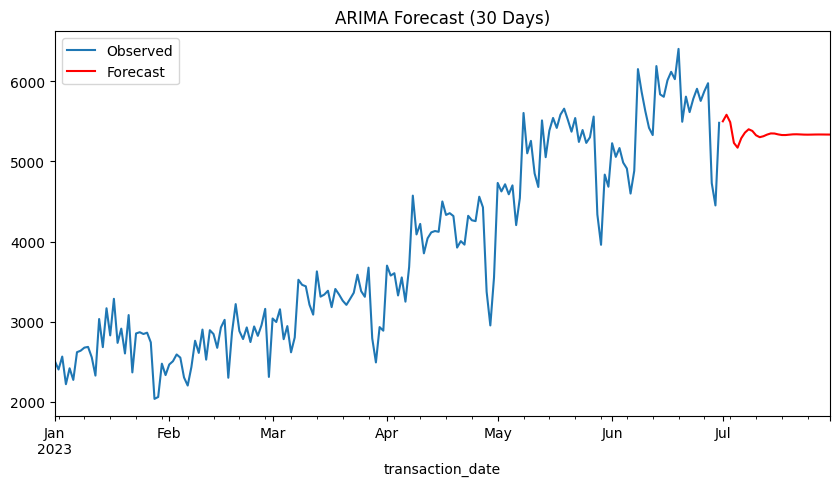

In [45]:
#Fit ARIMA Model (auto parameters for now)

# Fit ARIMA(p,d,q) model – try (5,1,0) as a start
model = ARIMA(daily_sales, order=(5,1,0))
arima_result = model.fit()

# Forecast next 30 days
forecast = arima_result.forecast(steps=30)

# Plot
plt.figure(figsize=(10,5))
daily_sales.plot(label='Observed')
forecast.plot(label='Forecast', color='red')
plt.title("ARIMA Forecast (30 Days)")
plt.legend()
plt.show()


In [135]:
import pandas as pd
print("daily_sales dataFrame Info:")
daily_sales.info()
print("forecasting dataFrame Info:")
pd.DataFrame(arima_result.forecast(steps=30)).info()


daily_sales dataFrame Info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 181 entries, 2023-01-01 to 2023-06-30
Series name: total_price
Non-Null Count  Dtype  
--------------  -----  
181 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB
forecasting dataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-07-01 to 2023-07-30
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted_mean  30 non-null     float64
dtypes: float64(1)
memory usage: 480.0 bytes


Let’s use Auto ARIMA to automatically select the best ARIMA parameters 
(𝑝,𝑑,𝑞) using AIC/BIC scoring.

In [46]:
%pip install numpy pandas matplotlib statsmodels scikit-learn

Note: you may need to restart the kernel to use updated packages.


Workaround Without pmdarima: Use statsmodels + AIC Loop

Instead of pmdarima.auto_arima, you can create a simple grid search using statsmodels to find the best ARIMA parameters (p, d, q) by minimizing AIC (Akaike Information Criterion).

In [147]:
#Step-by-Step: Grid Search ARIMA (Without pmdarima)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings
import numpy as np

warnings.filterwarnings("ignore")

# Your time series
sales_ts = df.groupby('transaction_date')['total_price'].sum()

# Define parameter ranges
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

best_aic = np.inf
best_params = None
best_model = None

for param in pdq_combinations:
    try:
        model = ARIMA(sales_ts, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
    except:
        continue

print(f"Best ARIMA parameters: {best_params} with AIC: {best_aic}")


Best ARIMA parameters: (1, 2, 2) with AIC: 2631.651397011826


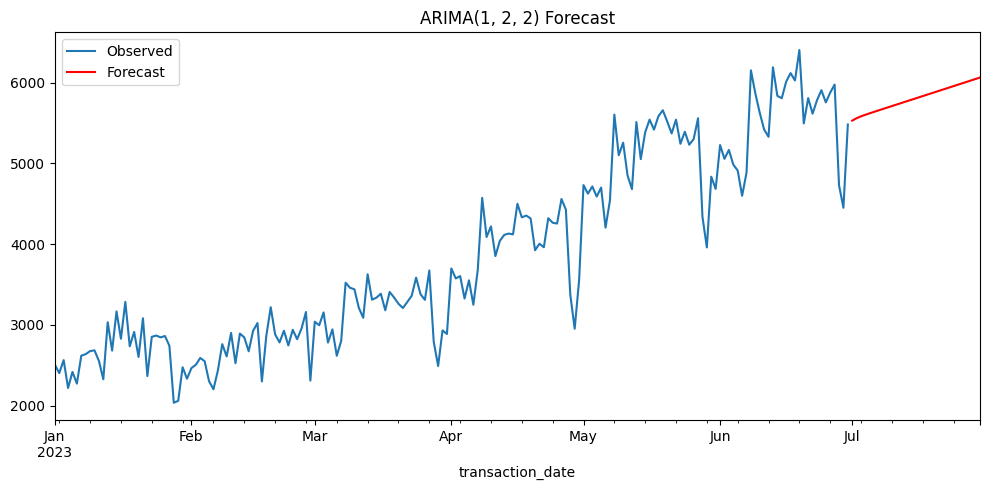

In [148]:
#Forecast with Best Model 
forecast = best_model.forecast(steps=30)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sales_ts.plot(label='Observed')
forecast.plot(label='Forecast', color='red')
plt.title(f"ARIMA{best_params} Forecast")
plt.legend()
plt.tight_layout()
plt.show()


expand ARIMA to seasonal ARIMA (SARIMA) — a more powerful version that captures weekly/monthly patterns, which is especially relevant for coffee shop sales.

📈 SARIMA (Seasonal ARIMA) Forecasting
SARIMA = ARIMA + Seasonality
Defined as: ARIMA(p, d, q)(P, D, Q, s)

 - p, d, q: Non-seasonal orders
 - P, D, Q: Seasonal orders
 - s: Seasonality period (e.g. 7 for weekly, 30 for monthly)

In [49]:
#SARIMA Model with statsmodels (Python 3.13+ compatible)
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [150]:
#Prepare Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Daily sales
sales_ts = df.groupby('transaction_date')['total_price'].sum()
sales_ts.index = pd.to_datetime(sales_ts.index)


In [151]:
# Define Grid Search for SARIMA Parameters
# Define parameter ranges
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 7  # Weekly seasonality

# All combinations of (p,d,q) x (P,D,Q)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = np.inf
best_params = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(sales_ts,
                          order=param,
                          seasonal_order=seasonal_param + (s,),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                best_model = results
        except:
            continue

print(f"Best SARIMA parameters: {best_params} with AIC: {best_aic}")


Best SARIMA parameters: ((1, 1, 1), (0, 1, 1)) with AIC: 2429.046115603226


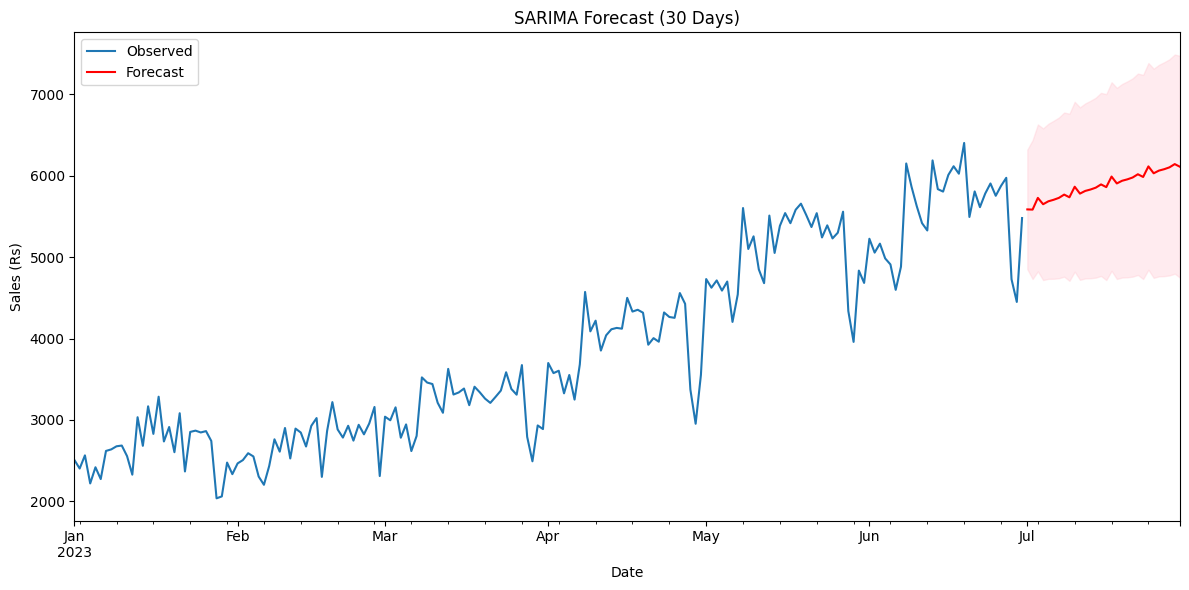

In [152]:
#Forecast Using Best SARIMA Model
# Forecast 30 days ahead
forecast = best_model.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(12,6))
sales_ts.plot(label='Observed')
forecast_mean.plot(label='Forecast', color='red')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Forecast (30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales (Rs)")
plt.legend()
plt.tight_layout()
plt.show()


#### ✅ Optional Enhancements for a Complete Data Science Project

1. 📍 Store-Level Forecasting with SARIMA
Repeat the SARIMA process per store to forecast localized demand and guide staffing, stocking, and marketing at each location.

In [53]:
store_name[5]

's'

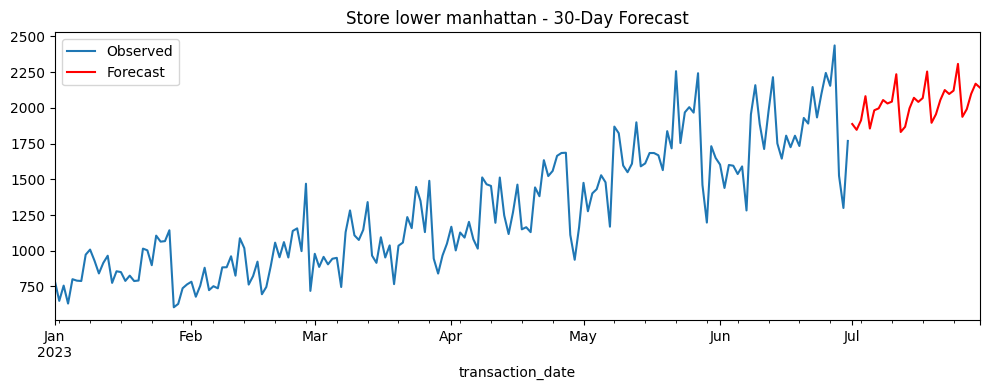

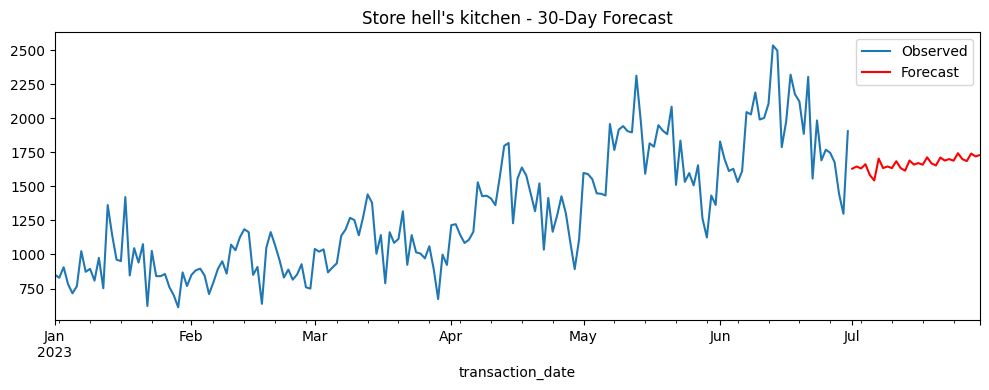

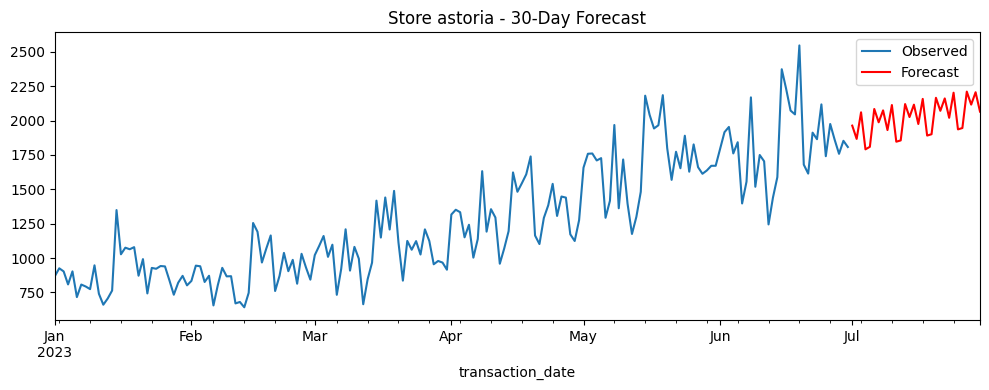

In [54]:
s_name = {5:"lower manhattan", 8:"hell's kitchen", 3:"astoria"}
for store_id in df['store_id'].unique():
    store_sales = df[df['store_id'] == store_id].groupby('transaction_date')['total_price'].sum()
    if len(store_sales) > 60:  # Ensure enough data
        model = SARIMAX(store_sales, order=(1,1,1), seasonal_order=(1,1,1,7))
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=30).predicted_mean

        plt.figure(figsize=(10,4))
        store_sales.plot(label='Observed')
        forecast.plot(label='Forecast', color='red')
        plt.title(f"Store {s_name[store_id]} - 30-Day Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()


3. 🎯 Promotion Impact Analysis

Evaluate how sales changed during a known promotional period.

In [55]:
# Example: Mark April 1–10 as a promotion
df['promo'] = df['transaction_date'].between('2023-04-01', '2023-04-10')

# Compare average sales
promo_sales = df[df['promo'] == True]['total_price'].sum()
normal_sales = df[df['promo'] == False]['total_price'].sum() / (len(df['transaction_date'].unique()) - 10) * 10

print(f"Promo Period Sales: {promo_sales:.2f}")
print(f"Expected Sales without Promo: {normal_sales:.2f}")


Promo Period Sales: 37575.94
Expected Sales without Promo: 38668.79


4. 🧠 Price Sensitivity Analysis

Explore how changes in unit_price affect transaction_qty.

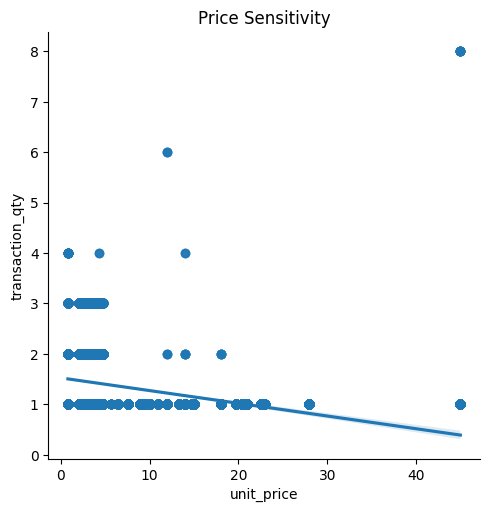

In [56]:
import seaborn as sns
sns.lmplot(x='unit_price', y='transaction_qty', data=df)
plt.title("Price Sensitivity")
plt.show()

5. 👥 Customer Segmentation Visualization

Use RFM segments to tailor marketing. Example:

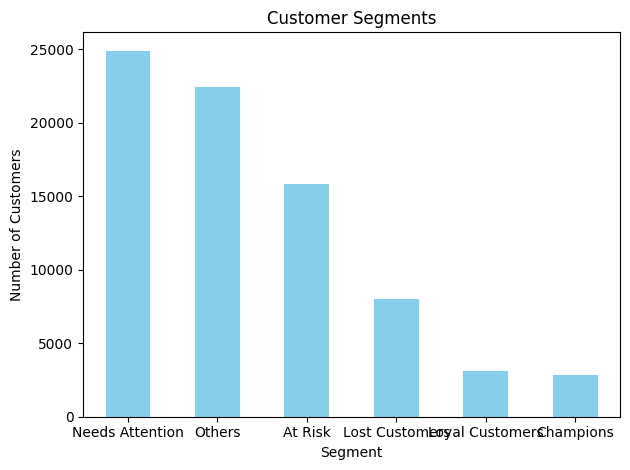

In [57]:
rfm_counts = rfm['Segment'].value_counts()
rfm_counts.plot(kind='bar', color='skyblue')
plt.title("Customer Segments")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Product-Level Demand Forecasting (Using SARIMA)
We’ll forecast daily sales for each top-selling product category or specific product_id.

In [58]:
#Identify Top Products
# Top 5 products by total sales
top_products = df.groupby('product_id')['total_price'].sum().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 product IDs:", top_products)

Top 5 product IDs: [61, 59, 39, 41, 55]


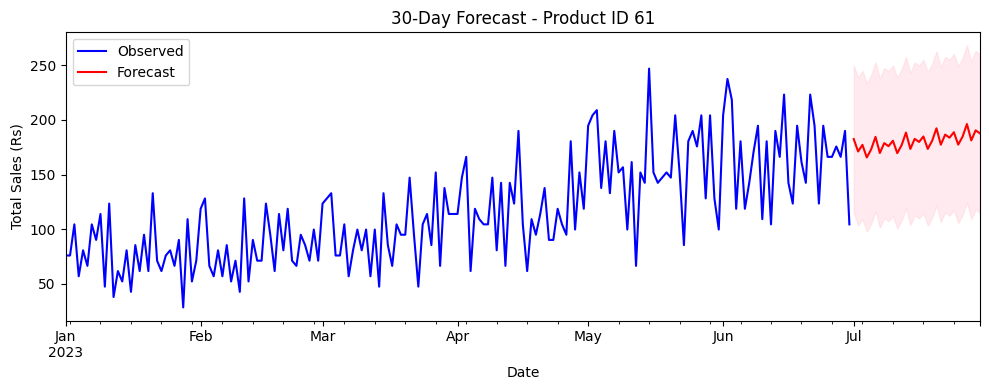

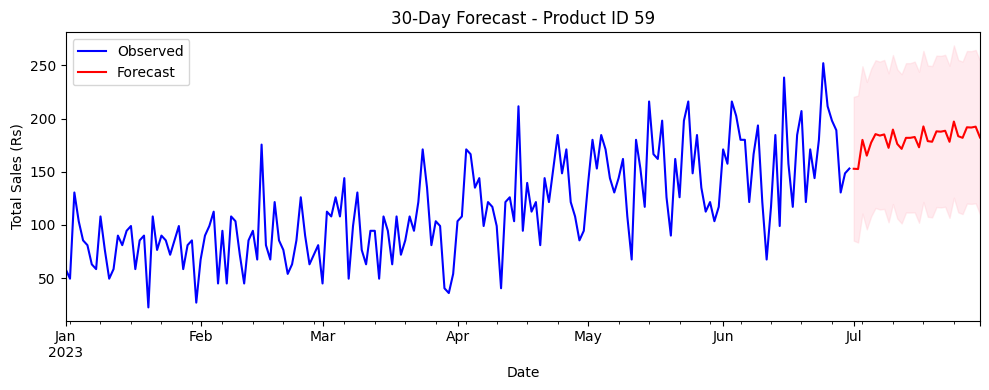

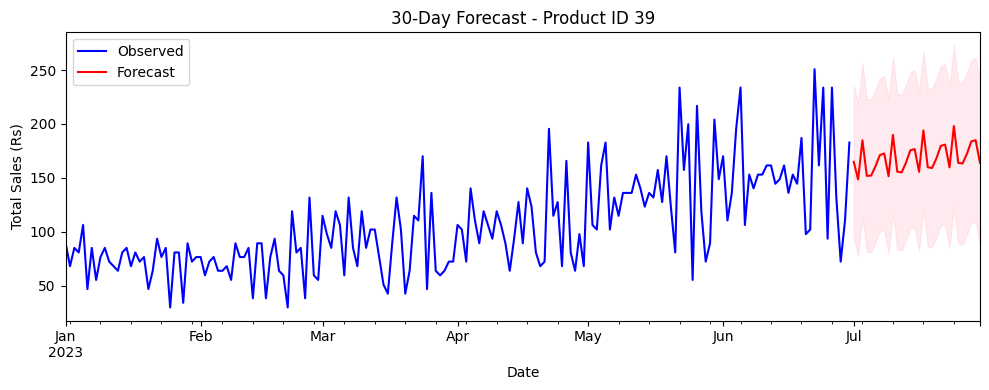

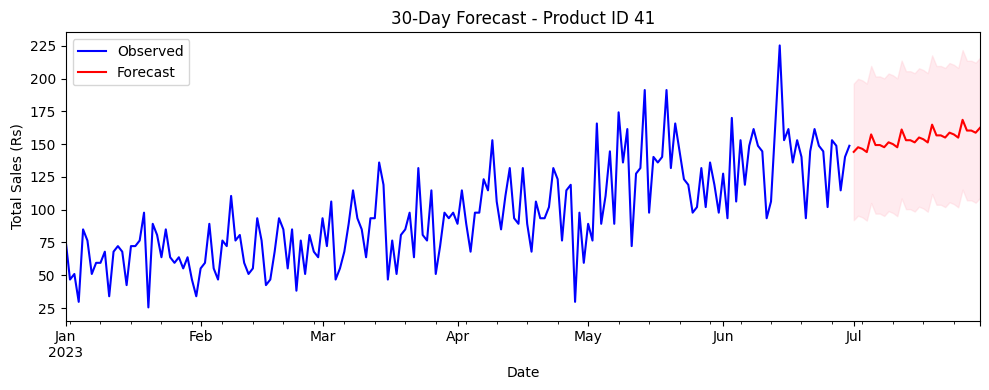

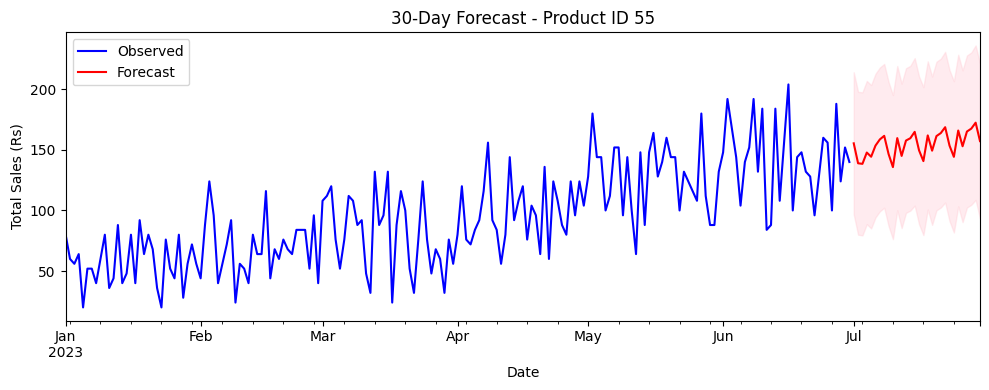

In [59]:
#Forecast for Each Product (using SARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

for pid in top_products:
    product_sales = df[df['product_id'] == pid].groupby('transaction_date')['total_price'].sum()
    product_sales = product_sales.asfreq('D').fillna(0)  # fill missing days

    if len(product_sales) < 60:
        continue  # skip if too little data

    model = SARIMAX(product_sales,
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=30)
    forecast_mean = forecast.predicted_mean
    ci = forecast.conf_int()

    # Plot forecast
    plt.figure(figsize=(10, 4))
    product_sales.plot(label='Observed', color='blue')
    forecast_mean.plot(label='Forecast', color='red')
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f"30-Day Forecast - Product ID {pid}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales (Rs)")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### 🛠️ Optional Customizations for Product-Level Forecasting


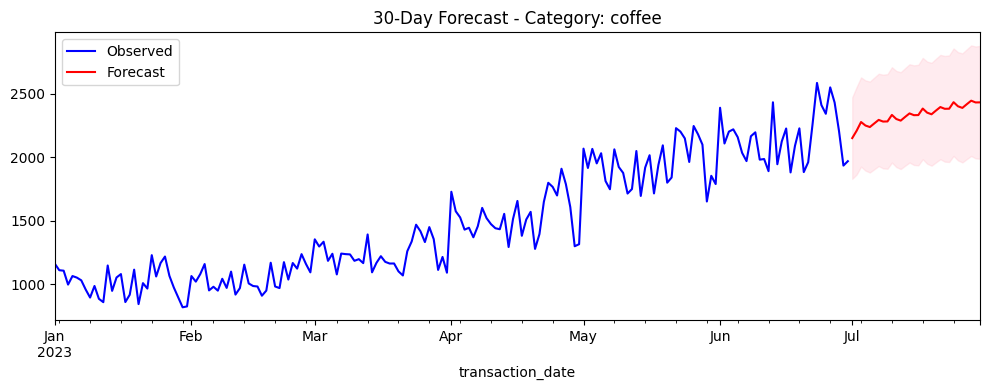

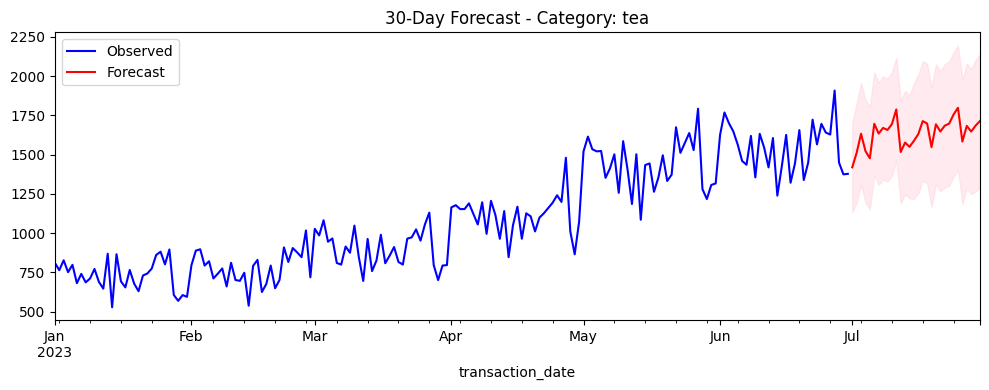

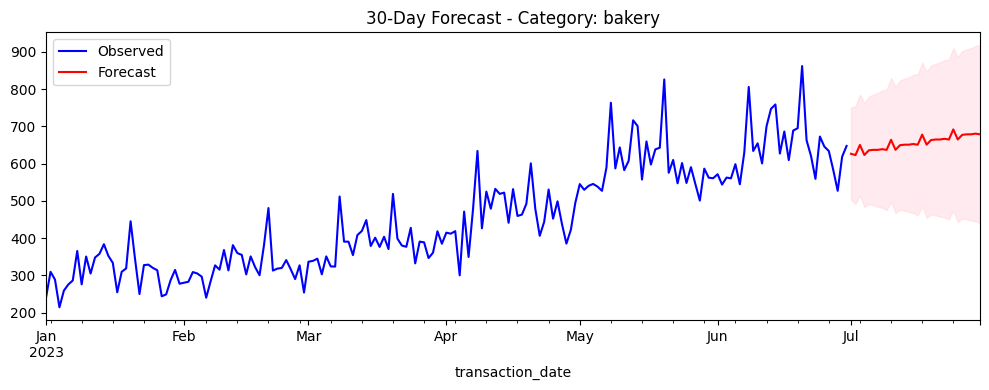

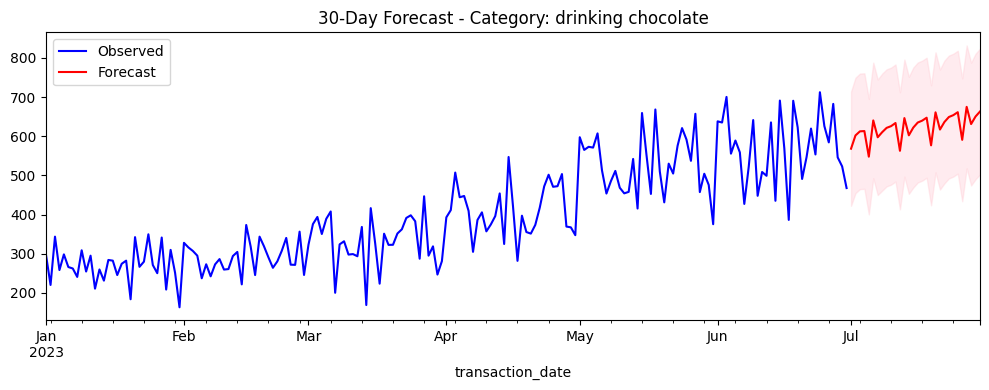

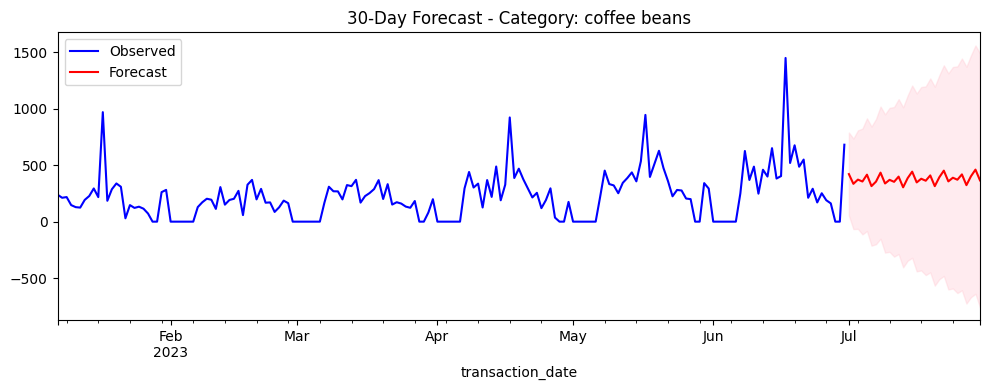

In [60]:
#Forecast by product_category Instead of product_id
#This helps reduce noise and capture more generalizable trends.
top_categories = df.groupby('product_category')['total_price'].sum().sort_values(ascending=False).head(5).index.tolist()

for category in top_categories:
    cat_sales = df[df['product_category'] == category].groupby('transaction_date')['total_price'].sum()
    cat_sales = cat_sales.asfreq('D').fillna(0)

    if len(cat_sales) < 60:
        continue

    model = SARIMAX(cat_sales, order=(1,1,1), seasonal_order=(1,1,1,7))
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=30)
    
    plt.figure(figsize=(10,4))
    cat_sales.plot(label='Observed', color='blue')
    forecast.predicted_mean.plot(label='Forecast', color='red')
    plt.fill_between(forecast.conf_int().index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f"30-Day Forecast - Category: {category}")
    plt.legend()
    plt.tight_layout()
    plt.show()


3. 📤 Export Forecasts to CSV for Reporting or Dashboards

You can export the forecasts for further use in Excel, Power BI, or dashboards.

In [61]:
forecast_df = forecast.predicted_mean.reset_index()
forecast_df.columns = ['Date', 'Forecasted_Sales']
forecast_df.to_csv(f'forecast_product_{pid}.csv', index=False)

🔍 Compare Trends Over Time (Multiple Products or Categories)

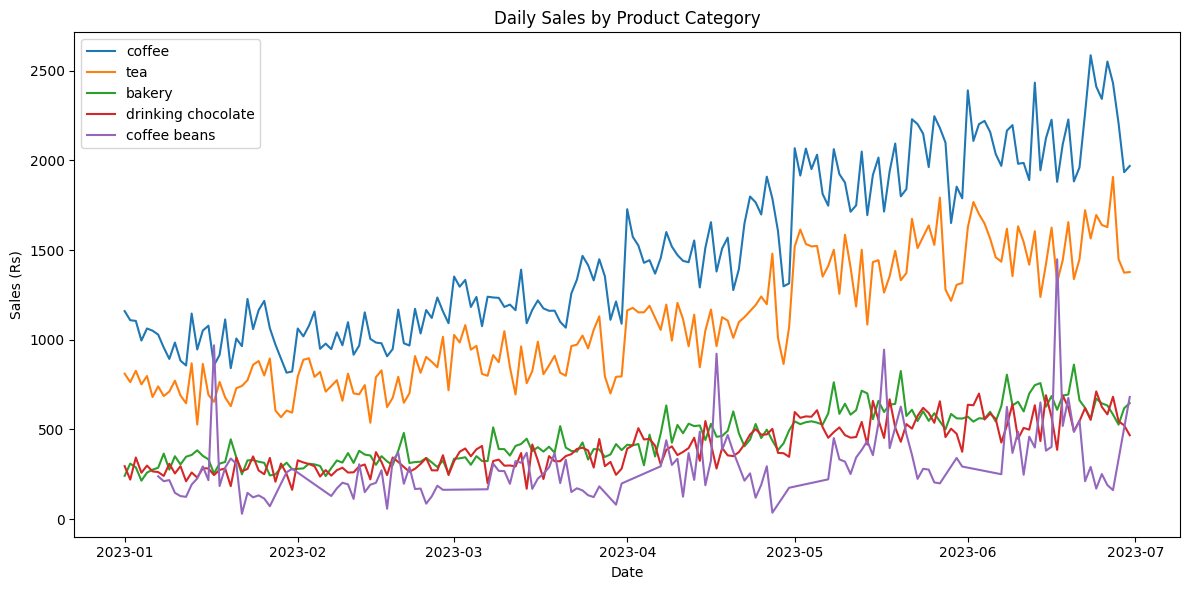

In [62]:
import seaborn as sns

# Example: Plot time series of top categories
plt.figure(figsize=(12, 6))
for category in top_categories:
    cat_ts = df[df['product_category'] == category].groupby('transaction_date')['total_price'].sum()
    plt.plot(cat_ts, label=category)

plt.title("Daily Sales by Product Category")
plt.xlabel("Date")
plt.ylabel("Sales (Rs)")
plt.legend()
plt.tight_layout()
plt.show()


#### Add Forecast Logic (Optional — One-Time Generation)

In [63]:
# Forecast total sales per day
from statsmodels.tsa.statespace.sarimax import SARIMAX

sales_daily = df.groupby('transaction_date')['total_price'].sum().asfreq('D').fillna(0)
model = SARIMAX(sales_daily, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=30)

forecast_df = forecast.predicted_mean.reset_index()
forecast_df.columns = ['Date', 'Forecasted_Sales']

forecast_df.to_csv("../../data/processed/forecast_30days.csv", index=False)


In [67]:
df['total_price'].sum()

np.float64(698812.3300000002)